---
---

# <p style="color: #ffd700; background-color: #006400;"> EYE FOR BLIND

This capstone project involves developing a deep learning model to describe images through speech. The objective is to assist visually impaired individuals by generating spoken captions for images using the **[Flickr8K](https://www.kaggle.com/datasets/adityajn105/flickr8k)** dataset. The project integrates deep learning and natural language processing, employing a CNN-RNN architecture with an attention mechanism. A CNN-based encoder will extract features from images, which will be processed by an RNN decoder to generate captions. These captions will then be converted to speech using a text-to-speech library.

### Project Pipeline:
1. **Data Understanding:** Load and interpret the dataset.
2. **Data Preprocessing:** Format both images and captions.
3. **Train-Test Split:** Prepare and split the data for training and testing.
4. **Model Building:** Construct the image captioning model, including the Encoder, Attention, and Decoder components.
5. **Model Evaluation:** Assess the model's performance using greedy search and beam search using BLEU score.

---
---

## Table of Content

* [Install and Import the required libraries](#import)
* [Setup](#setup)
* [1. Data understanding](#1)
    * [1.1 Import the dataset and read image](#11)
    * [1.2 Visualise both the images & text present in the dataset](#12)
	* [1.3 Create a dataframe which summarizes the image, path & captions as a dataframe](#13)
	* [1.4 Visualize images along with their captions](#14)
	* [1.5 Create a list which contains all the captions & path](#15)
	* [1.6 Visualise the top 30 occuring words in the captions](#16)
* [2. Pre-Processing the captions](#2)
    * [2.1 Create the tokenizer for top 5000 words and fill others with \<unk>](#21)
    * [2.2 Create word-to-index and index-to-word mappings](#22)
    * [2.3 Pad all sequences to be the same length as the longest one](#23)
* [3. Pre-processing the images](#3)
* [4. Load the pretrained Imagenet weights of Inception net V3](#4)
* [5. Dataset creation](#5)
	* [5.1 Apply train and test split](#51)
	* [5.2 Map image path to image feature](#52)
	* [5.3 Builder function to create train and test dataset](#53)
* [6. Model Building](#6)
	* [6.1 Set the parameters](#61)
	* [6.2 Encoder model](#62)
	* [6.3 Attention model](#63)
	* [6.4 Decoder model](#64)
* [7. Model training & optimization](#7)
	* [7.1 Set the optimizer & loss object](#71)
	* [7.2 Create checkpoint manager](#72)
	* [7.3 Create training & testing step functions](#73)
	* [7.4 Create loss function for the test dataset](#74)
	* [7.5 Train and optimize the model](#75)
* [8. Model Evaluation](#8)
	* [8.1 Greedy Search](#81)
	* [8.2 Beam Search](#82)
	* [8.3 Helper methods for evaluation](#83)
	* [8.4 Test on sample test data](#84)
* [9. Experiment on unseen data](#9)
* [Playground](#playground)

---
---
<a id='import'></a>
## Install and Import the required libraries

In [1]:
!pip install gtts

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
# Core libraries for data manipulation and numerical operations
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations and array handling

# Libraries for data visualization
import seaborn as sns  # Statistical data visualization
import matplotlib.pyplot as plt  # Plotting graphs and charts
import matplotlib.image as mpimg  # Reading and displaying images with Matplotlib
# Display plots inline within Jupyter notebooks
%matplotlib inline  

# File handling and utility libraries
import glob  # File pattern matching and retrieval
import time  # Time-related functions and performance measurement
import os  # Operating system interface
import warnings  # Manage warnings, useful to ignore unnecessary warnings
warnings.filterwarnings("ignore")  # Suppress warnings
import pickle # Store and retrieve files

# Machine learning and deep learning libraries
import tensorflow as tf  # Deep learning framework by Google
import keras  # High-level neural networks API, now integrated with TensorFlow
from keras.applications.inception_v3 import preprocess_input  # Preprocess input for InceptionV3 model
from keras.preprocessing.sequence import pad_sequences  # Pad sequences for uniform input size
from tensorflow.keras.preprocessing.text import Tokenizer  # Text tokenization utility
from keras import Input, layers  # For building neural network models

# NLP (Natural Language Processing) libraries
import nltk  # NLP toolkit
from nltk.corpus import stopwords  # Stopwords list for text processing
nltk.download('stopwords')  # Download stopwords corpus
from nltk.translate.bleu_score import sentence_bleu  # BLEU score calculation for evaluating text

# Utility libraries for data handling and progress display
from collections import Counter  # Count elements in collections, useful for frequency analysis
from sklearn.model_selection import train_test_split  # Split data into training and testing sets
from tqdm import tqdm  # Display progress bars

# Libraries for handling and processing images
from PIL import Image  # Image handling and manipulation

# Audio processing libraries
from gtts import gTTS  # Text-to-speech conversion using Google's TTS
from IPython.display import Audio  # Display audio in Jupyter notebooks

[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
---
<a id='setup'></a>
## Setup
**NOTE:** Configure the paths according to your local setup.

In [3]:
# Define the base directory for the Flickr dataset
DATA_DIR = "/home/datasets/flickr"

# Define the directory where the images are stored within the dataset
IMAGES_DIR = os.path.join(DATA_DIR, 'Images')

# Path to the captions file that contains image descriptions
CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions.txt')

# Directory path to save models during training
MODEL_PATH = "/home/EyeForBlind/model"

# Directory path to save model checkpoints during training
CHECKPOINT_PATH = os.path.join(MODEL_PATH, 'checkpoints')

# Directory path to save or load the tokenizer used for text processing in the model
TOKENIZER_PATH = os.path.join(MODEL_PATH, 'tokenizer.pkl')

# Directory path to save the processed images after any operations
OUTPUT_IMG_PATH = "/home/EyeForBlind/feature_images"

# Directory path to save the generated caption audio
CAPTION_AUDIO_PATH = "/home/EyeForBlind/generated_caption_audio"

# Set the batch size and the buffer size for the training
BATCH_SIZE = 32
BUFFER_SIZE = 1000

---
---
<a id='1'></a>
## 1. Data understanding

1. Import the dataset and read image
2. Visualise both the images & text present in the dataset
3. Create a dataframe which summarizes the image, path & captions as a dataframe
4. Visualize images along with their captions
5. Create a list which contains all the captions & path
6. Visualise the top 30 occuring words in the captions

---
<a id='11'></a>
### 1.1) Import the dataset and read image

The objective is to load and list all image files from a specified directory into a variable, allowing for further processing or analysis of these images.

#### Steps Performed:
1. **Define the Images Directory**:
   - The `IMAGES_DIR` variable is assigned to `images`, which represents the directory path where the images are stored.

2. **Retrieve All Image Files**:
   - `glob.glob()` is used to search for all files with the `.jpg` extension within the specified directory.
   - The `recursive=True` parameter ensures that the search includes all subdirectories (if there were any).
   - The result is stored in the `all_imgs` list, which contains the full file paths of all the images.

In [4]:
# Retrieve all image files with .jpg extension from the specified directory and its subdirectories
all_imgs = glob.glob(IMAGES_DIR + '/*.jpg', recursive=True)

# Print the total number of images found in the dataset
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


---
<a id='12'></a>
### 1.2) Visualise both the images & text present in the dataset

The objective is to visualize a subset of the images from the dataset in a grid layout, providing a quick overview of the images.

#### Steps Performed:

1. **Set Up the Grid Layout**:
   - The variables `num_rows` and `num_cols` define the dimensions of the grid (4 rows and 3 columns).
   - `num_imgs` calculates the total number of images to be displayed (4 rows * 3 columns = 12 images).

2. **Create a Figure for Plotting**:
   - `plt.figure(figsize=(16,12))` initializes a new figure with a specified size (16x12) to contain the image grid.

3. **Plot the Images**:
   - A `for` loop iterates over the range of `num_imgs`, which is 12 in this case.
   - Inside the loop:
     - `plt.subplot(num_rows, 2*num_cols, 2*i+1)` creates a subplot for each image. The subplot index `2*i+1` ensures that the images are placed in every other position in the grid (spaced out by one).
     - `plt.xticks([])` and `plt.yticks([])` remove the x and y axis ticks for a cleaner visualization.
     - `plt.imshow(mpimg.imread(all_imgs[i]))` reads and displays each image from the `all_imgs` list in the subplot.

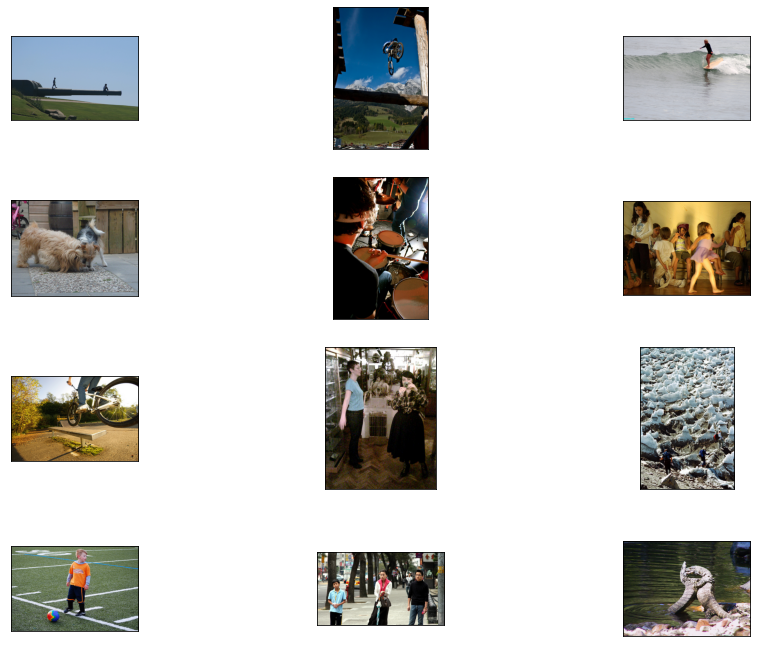

In [5]:
# Define the number of rows and columns for the grid
num_rows = 4
num_cols = 3
num_imgs = num_rows * num_cols  # Total number of images to display

# Create a figure with specified size for the grid of images
plt.figure(figsize=(16, 12))

# Loop to plot each image in the grid
for i in range(num_imgs):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)  # Create subplots, spaced out by one position
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.imshow(mpimg.imread(all_imgs[i]))  # Read and display the image

The objective is to load and process a text file containing image captions, reading the data into a structured format that can be used for further analysis or processing.

#### Steps Performed:

1. **Define a Function to Load the Text File**:
   - The `load_doc()` function is created to read the content of a text file, process it, and return the data in a structured list format.
   - `filename` is the path to the text file containing the captions.

2. **Open and Read the File**:
   - The file is opened in read mode using `open(filename, 'r')`.
   - The contents of the file are read line by line using a generator expression that strips any trailing whitespace from each line.
   - `filter(None, ...)` is used to remove any empty lines from the text.

3. **Process the Text Data**:
   - An empty list `lst_line` is initialized to store the processed data.
   - The code iterates over each line in `text` (non-empty lines from the file), and splits each line into two parts using a comma `,` as the delimiter, but only at the first occurrence (using `maxsplit=1`).
   - Each split line is appended to `lst_line`, resulting in a list of lists, where each inner list contains two elements: the image file name and the corresponding caption.

4. **Return and Display the Processed Data**:
   - The processed data `lst_line` is returned by the `load_doc()` function and stored in the `doc` variable.
   - The first 10 entries of `doc` are printed to verify the loading and processing of the captions.


In [6]:
# Import the dataset and read the captions text file into a separate variable
def load_doc(filename):
    # Open the file in read mode and remove any trailing whitespace from each line
    file = open(filename, 'r')
    text = list(filter(None, (line.rstrip() for line in file)))
    file.close()  # Close the file after reading
    
    # Initialize a list to store processed lines
    lst_line = []
    
    # Process each line by splitting it into an image identifier and caption
    for line in text:
        lst_line.append(line.split(',', maxsplit=1))  # Split at the first comma and store the result
    
    return lst_line  # Return the processed list of image identifiers and captions

# Load and process the captions file
doc = load_doc(CAPTIONS_FILE)

# Print the first 10 entries to verify the data
print(doc[:10])

[['image', 'caption'], ['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .'], ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'], ['1001773457_577c3a7d70.jpg', 'A black dog and a tri-colored dog playing with each other on the road .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a white dog with brown spots are staring at each other in the street .'], ['1001773457_577c3a7d70.jpg', 'Two dogs of different breeds looking at each other on the road .']]


---
<a id='13'></a>
### 1.3) Create a dataframe which summarizes the image, path & captions as a dataframe

- Create a dataframe which summarizes the image, path & captions as a dataframe.
- Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

The objective is to organize the image IDs, their corresponding file paths, and captions into a structured pandas DataFrame, which allows for easy manipulation, analysis, and visualization of the data.

#### Steps Performed:

1. **Extract Image IDs**:
   - The list comprehension `[i[0] for i in doc[1:]]` extracts the first element (image ID) from each entry in the `doc` list, starting from the second element (`doc[1:]`) to skip any header or irrelevant first line.
   - The extracted image IDs are stored in the `all_img_id` list.

2. **Generate Full Image Paths**:
   - The list comprehension `[os.path.join(IMAGES_DIR, i[0]) for i in doc[1:]]` constructs the full file path for each image by joining the base image directory (`IMAGES_DIR`) with the image ID.
   - These paths are stored in the `all_img_vector` list, representing the full path to each image.

3. **Extract Captions**:
   - The list comprehension `[i[1] for i in doc[1:]]` extracts the second element (caption) from each entry in `doc`, starting from the second element.
   - These captions are stored in the `annotations` list.

4. **Create a DataFrame**:
   - The `pd.DataFrame` constructor is used to create a DataFrame from a list of tuples generated by `zip(all_img_id, all_img_vector, annotations)`.
   - The DataFrame has three columns: 'ID' for image IDs, 'Path' for the image paths, and 'Captions' for the corresponding captions.

5. **Display the First 10 Entries**:
   - `df.head(10)` displays the first 10 rows of the DataFrame, providing a quick preview of how the data is structured.

In [7]:
# Extract all image IDs from the processed data, skipping the first element which is the header
all_img_id = [i[0] for i in doc[1:]]

# Generate the full path for each image by joining the directory path with the image ID
all_img_vector = [os.path.join(IMAGES_DIR, i[0]) for i in doc[1:]]

# Extract all captions from the processed data
annotations = [i[1] for i in doc[1:]]

# Create a DataFrame to organize the image IDs, paths, and captions
df = pd.DataFrame(list(zip(all_img_id, all_img_vector, annotations)), columns=['ID', 'Path', 'Captions'])

# Display the first 10 rows of the DataFrame to verify the data structure
df.head(10)

ID  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                                Path  \
0  /home/datasets/flickr/Images/1000268201_693b08...   
1  /home/datasets/flickr/Images/1000268201_693b08...   
2  /home/datasets/flickr/Images/1000268201_693b08...   
3  /home/datasets/flickr/Images/1000268201_693b08...   
4  /home/datasets/flickr/Images/1000268201_693b08...   
5  /home/datasets/flickr/Images/1001773457_577c3a...   
6  /home/datasets/flickr/Images/1001773457_577c3a...   
7  /home/datasets/flickr/Images/1001773457_577c3a...   
8  /home/datasets/flickr/Images/1001773457_577c3a...   
9  /home/datasets/flickr/Images/1001773457_577c3a...   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

---
<a id='14'></a>
### 1.4) Visualize images along with their captions

The objective is to visualize a subset of images from the dataset along with their associated captions. This visualization helps in verifying the alignment between images and captions and provides an overview of the data.

#### Steps Performed:

1. **Select Unique Image Paths**:
   - `img_path = list(set(df.Path[:20]))` selects the first 20 image paths from the DataFrame. Since each image has 5 captions, this effectively chooses 4 unique images for visualization.

2. **Initialize Counter**:
   - `count` is initialized to 1 to keep track of the subplot position for each image and its captions.

3. **Loop Through Each Image Path**:
   - For each `path` in `img_path`, the following steps are performed:

   - **Read and Preprocess the Image**:
     - `tf.io.read_file(path)` reads the image file from the specified path.
     - `tf.image.decode_jpeg(img, channels=3)` decodes the JPEG image into a tensor with 3 color channels.
     - `tf.image.convert_image_dtype(img, tf.float32)` converts the image data to float32 type for consistency.
     - `tf.image.resize(img, [224, 224])` resizes the image to 224x224 pixels.

   - **Plot the Image**:
     - A new figure is created with `fig = plt.figure(figsize=(10,20))`.
     - The image is displayed in a subplot using `ax.imshow(img)`, with `xticks` and `yticks` turned off for a cleaner look.

   - **Prepare for Caption Plotting**:
     - `count` is incremented to move to the next subplot.
     - The next subplot is prepared to display captions, with `plt.axis('off')` to turn off axis lines and labels.
     - `ax.set_xlim(0,1)` and `ax.set_ylim(0,5)` set the limits of the subplot to ensure sufficient space for captions.

   - **Display Captions**:
     - Captions corresponding to the current image are retrieved using `img_cap = df.loc[df['Path'] == path, 'Captions']`.
     - Each caption is added to the subplot using `ax.text(0, i, img_cap.iloc[i], fontsize=15)` to place the text at the appropriate position.

   - **Increment Counter**:
     - `count` is incremented by 1 to adjust for the next image-caption pair.

4. **Show the Plot**:
   - `plt.show()` displays the final plot containing images and their captions.

2024-08-20 09:42:38.906917: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-20 09:42:38.906979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


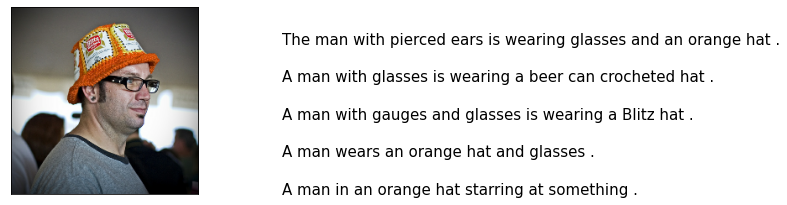

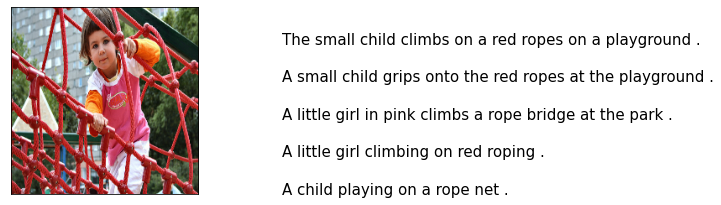

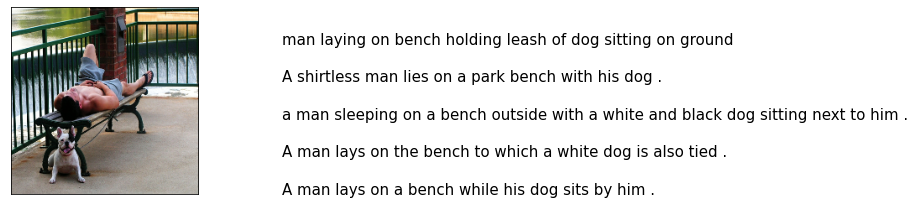

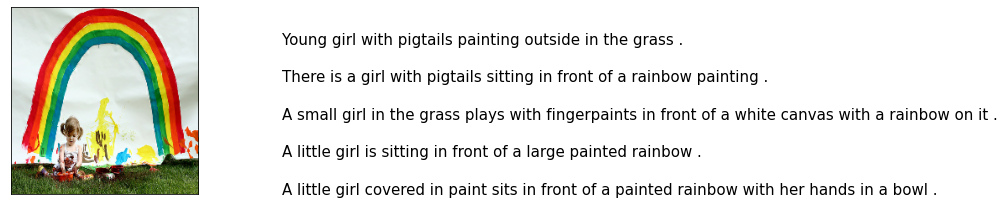

In [8]:
# Select unique image paths from the DataFrame (4 unique images, each with 5 captions)
img_path = list(set(df.Path[10:30]))

count = 1  # Initialize a counter for subplot positioning

# Loop through each unique image path
for path in img_path:
    # Read and preprocess the image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [224, 224])
    
    # Create a new figure and add the image to the subplot
    fig = plt.figure(figsize=(10, 20))
    ax = fig.add_subplot(5, 2, count, xticks=[], yticks=[])
    ax.imshow(img)
    
    count += 1  # Increment the counter for the next subplot
    
    # Prepare the next subplot for captions
    ax = fig.add_subplot(5, 2, count)
    plt.axis('off')  # Turn off the axis
    ax.plot()  # Add an empty plot to create space for captions
    ax.set_xlim(0, 1)  # Set x-axis limits
    ax.set_ylim(0, 5)  # Set y-axis limits
    
    # Retrieve and display the captions for the current image
    img_cap = df.loc[df['Path'] == path, 'Captions']
    for i in range(len(img_cap)):
        ax.text(0, i, img_cap.iloc[i], fontsize=15)  # Display each caption
    
    count += 1  # Increment the counter to adjust for the next image-caption pair

# Display the final plot with images and their captions
plt.show()

---
<a id='15'></a>
### 1.5) Create a list which contains all the captions & path

This code processes each line in the annotations list by splitting it into words, converting them to lowercase, removing punctuation, filtering out short and non-alphabetic tokens, and then joining the cleaned words back into a string.

In [9]:
import string

# Create a translation table for removing punctuation
remove_punctuation = str.maketrans('', '', string.punctuation)

# Iterate over each line in the annotations list
for i in range(len(annotations)):
    line = annotations[i]
    
    # Split the line into individual words/tokens
    line = line.split()
    
    # Convert each word to lowercase
    line = [word.lower() for word in line]
    
    # Remove punctuation from each word using the translation table
    line = [word.translate(remove_punctuation) for word in line]
    
    # Remove short tokens that are less than 2 characters long (e.g., single letters)
    line = [word for word in line if len(word) > 1]
    
    # Remove tokens that contain any non-alphabetic characters (e.g., numbers)
    line = [word for word in line if word.isalpha()]
    
    # Join the processed words back into a single string and update the list
    annotations[i] = ' '.join(line)

The objective is to preprocess the captions by adding special start and end tokens, and to create lists containing all captions and image paths for further use in data processing or model training.

#### Steps Performed:

1. **Preprocess Captions**:
   - `annotations = ['<start> '+ i + ' <end>' for i in df.Captions]` creates a new list of captions by adding the special tokens `<start>` at the beginning and `<end>` at the end of each caption.
   - This preprocessing step is often used in natural language processing tasks to mark the beginning and end of sequences.

2. **Create a List of Image Paths**:
   - `all_img_path = [i for i in df.Path]` creates a list of all image paths extracted from the DataFrame. This list will be used for accessing or processing images in relation to the captions.

In [10]:
# Create a list containing all captions with <start> and <end> tokens added
annotations = ['<start> '+ i + ' <end>' for i in annotations]

# Print the first 8 captions to verify that the tokens have been added
print('Captions after adding start and end tokens', annotations[:8])

# Create a list containing all the image paths
all_img_path = [i for i in df.Path]

# Print the total number of captions and images present in the dataset
print("\nTotal captions present in the dataset : " + str(len(annotations)))
print("Total images present in the dataset   : " + str(len(all_img_path)))

# Identify unique image filenames (IDs) from the DataFrame
uni_filenames = np.unique(df.ID.values)

# Print the number of unique image filenames
print("\nThe number of unique file names : {}".format(len(uni_filenames)))

# Calculate and print the distribution of the number of captions for each image
caption_counts = Counter(df.ID.values)  # Count captions per image ID
caption_distribution = Counter(caption_counts.values())  # Frequency distribution of caption counts
print("The distribution of the number of captions for each image:", caption_distribution)

Captions after adding start and end tokens ['<start> child in pink dress is climbing up set of stairs in an entry way <end>', '<start> girl going into wooden building <end>', '<start> little girl climbing into wooden playhouse <end>', '<start> little girl climbing the stairs to her playhouse <end>', '<start> little girl in pink dress going into wooden cabin <end>', '<start> black dog and spotted dog are fighting <end>', '<start> black dog and tricolored dog playing with each other on the road <end>', '<start> black dog and white dog with brown spots are staring at each other in the street <end>']

Total captions present in the dataset : 40455
Total images present in the dataset   : 40455

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


---
<a id='16'></a>
### 1.6) Visualise the top 30 occuring words in the captions

The objective is to create a vocabulary from the captions, count the frequency of each word, and display the top 30 common words along with the size of the vocabulary.

#### Steps Performed:

1. **Create Vocabulary**:
   - An empty list `vocabulary` is initialized to store all the words from the captions.
   - The code iterates over each caption in `df.Captions.values`, converts the caption to lowercase, and splits it into individual words.
   - `vocabulary.extend(cap.lower().split())` adds these words to the `vocabulary` list.

2. **Count Word Frequencies**:
   - `val_count = Counter(vocabulary)` creates a `Counter` object from the `vocabulary` list, which counts the occurrences of each word.

In [11]:
# Create a list to hold all words from the captions
vocabulary = []

# Iterate over each caption, convert to lowercase, and split into words
for cap in df.Captions.values:
    vocabulary.extend(cap.lower().split())  # Add words to the vocabulary list

# Count the frequency of each word in the vocabulary
val_count = Counter(vocabulary)

# Print the size of the vocabulary (number of unique words)
print(f"Size of Vocab      : {len(set(vocabulary))}")

# Print the 30 most common words in the vocabulary along with their counts
print(f"Top Words in Vocab : {val_count.most_common(30)}")

Size of Vocab      : 9180
Top Words in Vocab : [('a', 61752), ('.', 34212), ('in', 18965), ('the', 18249), ('on', 10732), ('is', 9345), ('and', 8851), ('dog', 8126), ('with', 7761), ('man', 7238), ('of', 6712), ('two', 5224), ('white', 3935), ('black', 3825), ('boy', 3561), ('are', 3504), ('woman', 3385), ('girl', 3320), (',', 3210), ('to', 3173), ('wearing', 3061), ('at', 2905), ('people', 2856), ('water', 2779), ('red', 2672), ('young', 2607), ('brown', 2549), ('an', 2399), ('."', 2365), ('his', 2357)]


The objective is to visualize the top 30 most frequent words in the captions, excluding common stopwords, to better understand the prominent terms in the dataset.

#### Steps Performed:

1. **Retrieve Top 30 Words**:
   - `sort_lst = val_count.most_common(30)` retrieves the 30 most common words from the vocabulary along with their counts.

2. **Filter Out Stopwords**:
   - `stop = set(stopwords.words('english'))` creates a set of common English stopwords using the `stopwords` module from NLTK.
   - An empty list `x` is initialized to store the words that are not stopwords.
   - An empty list `y` is initialized to store the counts corresponding to the filtered words.
   - The loop `for word, count in sort_lst:` iterates through the top 30 words and their counts.
     - If the word is not a stopword (`if (word.lower() not in stop)`), it is added to the `x` list, and its count is added to the `y` list.

3. **Visualize the Data**:
   - `sns.barplot(x=y, y=x)` creates a horizontal bar plot with `y` (counts) on the x-axis and `x` (words) on the y-axis.
   - `.set_title('Top 30 occurring words')` sets the title of the plot.

Text(0.5, 1.0, 'Top 30 occurring words')

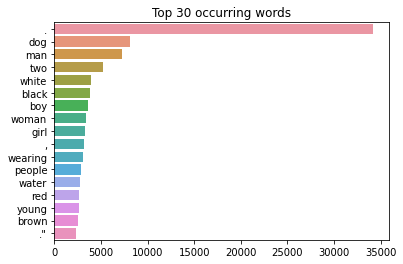

In [12]:
# Retrieve the top 30 most common words and their counts
sort_lst = val_count.most_common(30)

# Create a set of English stopwords to exclude from the visualization
stop = set(stopwords.words('english'))

# Initialize lists to hold words and their counts (excluding stopwords)
x, y = [], []

# Filter out stopwords and store remaining words and counts
for word, count in sort_lst:
    if (word.lower() not in stop):
        x.append(word)
        y.append(count)

# Create a horizontal bar plot for the top 30 occurring words
sns.barplot(x=y, y=x).set_title('Top 30 occurring words')

This code calculates the word count for each caption, and visualizes the distribution of caption word counts with a count plot. The mean word count is also calculated and marked on the plot with a vertical line, and a legend is added to display the mean value.

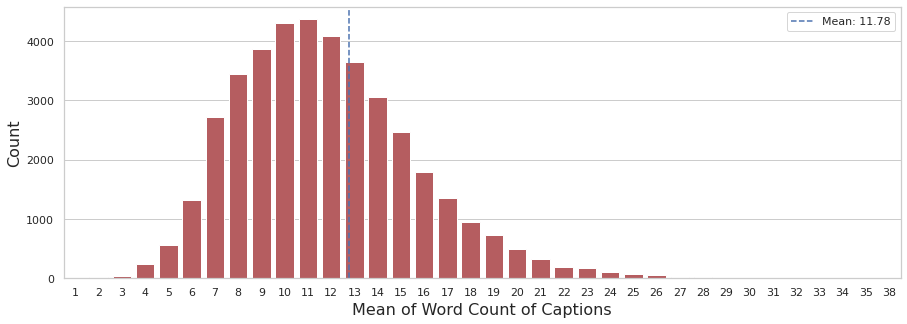

In [13]:
# Create a copy of the original DataFrame to avoid modifying it directly
caption_df = df.copy()

# Calculate the word count for each caption and add it as a new column in the DataFrame
caption_df['caption_word_count'] = caption_df["Captions"].str.split().str.len()

# Calculate the mean word count of all captions
mean = sum(caption_df['caption_word_count']) / len(caption_df['caption_word_count'])

# Set the style and font scale for the Seaborn plot
sns.set(style="whitegrid", font_scale=1)

# Create a figure with a specified size
plt.figure(figsize=(15, 5))

# Plot the distribution of caption word counts using a count plot
ax = sns.countplot(caption_df['caption_word_count'], color="r")

# Set the labels for the x and y axes
plt.xlabel('Mean of Word Count of Captions', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Draw a vertical line at the mean word count
ax.axvline(mean, color='b', linestyle='--')

# Add a legend to indicate the position of the mean
plt.legend({'Mean: {:.2f}'.format(mean): mean})

---
---
<a id='2'></a>
## 2. Pre-Processing the captions
1. Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory. Also, replace all other words with the unknown token "UNK" .
2. Create word-to-index and index-to-word mappings.
3. Pad all sequences to be the same length as the longest one.

<a id='21'></a>
### 2.1) Create the tokenizer for top 5000 words and fill others with \<unk>

The objective is to create a tokenizer that will be used to convert text (captions) into sequences of integers, focusing on the top 5,000 most frequent words. Any words outside this top 5,000 are replaced with a special `<unk>` token, which stands for "unknown."

#### Steps Performed:

1. **Set Top-K Words**:
   - `top_k = 5000` sets the value for the top 5,000 most frequent words that the tokenizer will focus on. These words will be included in the vocabulary of the tokenizer.

2. **Create Tokenizer**:
    - `tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.-/:;=?@[\]^_`{|}~ ')` initializes the tokenizer with several key parameters:
    - `num_words=top_k`: Limits the tokenizer's vocabulary to the top 5,000 most frequent words in the dataset.
    - `oov_token="<unk>"`: Specifies a token (`<unk>`) that will replace any words not in the top 5,000 (out-of-vocabulary words).
    - `filters='!"#$%&()*+.-/:;=?@[\]^_`{|}~ '`: Defines characters to be filtered out from the text before tokenization. This includes punctuation and other special characters.

3. **Fit Tokenizer on Captions**:
   - `tokenizer.fit_on_texts(annotations)` trains the tokenizer on the `annotations` list (which contains the captions with `<start>` and `<end>` tokens). This step builds the vocabulary based on the most frequent words in the captions and maps each word to an integer.

In [14]:
# Set the number of top words to consider in the vocabulary
top_k = 5000

# Create a tokenizer with a vocabulary size limited to the top 5000 words
# and replace out-of-vocabulary words with the <unk> token
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=top_k,
    oov_token="<unk>",
    filters='!"#$%&()*+.-/:;=?@[\]^_`{|}~ '
)

# Fit the tokenizer on the list of captions
tokenizer.fit_on_texts(annotations)

In [15]:
# Save the tokenizer object to a file using pickle
with open(TOKENIZER_PATH, "wb") as f:
    pickle.dump(tokenizer, f)

---
<a id='22'></a>
### 2.2) Create word-to-index and index-to-word mappings

The objective is to create mappings from words to their corresponding indices and vice versa using the tokenizer. It then converts the captions into sequences of integers based on these mappings. Additionally, it ensures that a padding token (`<pad>`) is added to the mappings and prints a sample caption along with its corresponding sequence.

#### Steps Performed:

1. **Create Word-to-Index Mapping**:
   - `word_index = tokenizer.word_index` creates a dictionary where each word in the tokenizer's vocabulary is mapped to a unique integer index. This mapping is used to convert words into numerical form.

2. **Create Index-to-Word Mapping**:
   - `index_word = tokenizer.index_word` creates a reverse mapping dictionary where each index is mapped back to the corresponding word. This is useful for decoding sequences of integers back into readable text.

3. **Convert Captions to Sequences**:
   - `train_seqs = tokenizer.texts_to_sequences(annotations)` converts the list of captions (annotations) into sequences of integers using the word-to-index mapping. Each word in the caption is replaced by its corresponding index.

4. **Add Padding Token to Mappings**:
   - `tokenizer.word_index['<pad>'] = 0` explicitly adds a padding token (`<pad>`) to the word-to-index mapping with an index of `0`. This is used for padding sequences to the same length when feeding them into models.
   - `tokenizer.index_word[0] = '<pad>'` adds the reverse mapping for the padding token, associating the index `0` with the `<pad>` token in the index-to-word dictionary.

In [16]:
# Create word-to-index mapping: maps each word to a unique integer
word_index = tokenizer.word_index

# Create index-to-word mapping: maps each index back to its corresponding word
index_word = tokenizer.index_word

# Convert the list of captions (annotations) into sequences of integers
train_seqs = tokenizer.texts_to_sequences(annotations)

# Add a padding token to the mappings, using 0 as the index for '<pad>'
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Print a sample caption to show its original text form
print('Caption: \n', annotations[3])

# Print the corresponding sequence of integers for the 4th caption
print('\nThe train sequence is: \n', train_seqs[3])

Caption: 
 <start> little girl climbing the stairs to her playhouse <end>

The train sequence is: 
 [2, 40, 19, 119, 5, 391, 20, 60, 2423, 3]


The objective is to visualize the top 30 most frequent words in the dataset after processing the text using the tokenizer. This visualization helps in understanding the most common words present in the captions, excluding stopwords.

#### Steps Performed:

1. **Get Word Counts from Tokenizer**:
   - `sort_lst = Counter(tokenizer.word_counts).most_common(30)` retrieves the 30 most common words and their counts from the tokenizer's word count dictionary. The tokenizer's `word_counts` attribute stores the frequency of each word in the dataset.

2. **Filter Out Stopwords**:
   - `stop = set(stopwords.words('english'))` creates a set of common English stopwords using the NLTK library. These words will be excluded from the visualization.
   - Two empty lists, `x` and `y`, are initialized to store the filtered words and their counts, respectively.
   - The loop `for word, count in sort_lst:` iterates over the top 30 words and their counts.
     - If a word is not in the stopwords set (`if (word.lower() not in stop)`), it is added to the `x` list, and its count is added to the `y` list.

3. **Visualize the Data**:
   - `sns.barplot(x=y, y=x)` creates a horizontal bar plot with `y` (counts) on the x-axis and `x` (words) on the y-axis.
   - `.set_title('Top 30 occurring words')` sets the title of the plot.

Text(0.5, 1.0, 'Top 30 occurring words')

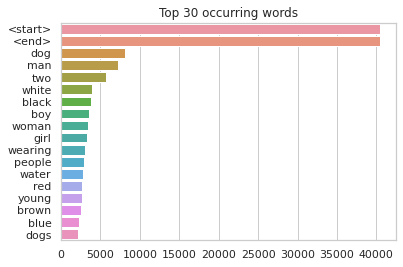

In [17]:
# Retrieve the top 30 most common words and their counts from the tokenizer
sort_lst = Counter(tokenizer.word_counts).most_common(30)

# Create a set of English stopwords to exclude from the visualization
stop = set(stopwords.words('english'))

# Initialize lists to hold words and their counts (excluding stopwords)
x, y = [], []

# Filter out stopwords and store remaining words and counts
for word, count in sort_lst:
    if word.lower() not in stop:
        x.append(word)
        y.append(count)

# Create a horizontal bar plot for the top 30 occurring words after text processing
sns.barplot(x=y, y=x).set_title('Top 30 occurring words')

---
<a id='23'></a>
### 2.3) Pad all sequences to be the same length as the longest one

The objective is to determine the maximum length of captions in the dataset, pad each caption sequence to this maximum length, and then store the padded sequences. Padding ensures that all captions have the same length, which is necessary for training models that require fixed-size inputs.

#### Steps Performed:

1. **Find Maximum Caption Length**:
   - `max_length = max([len(x) for x in train_seqs])` calculates the maximum length of the caption sequences in `train_seqs`. This is done by finding the length of each sequence and then taking the maximum value.

2. **Pad Sequences to Maximum Length**:
   - `cap_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)` pads each caption sequence in `train_seqs` to the maximum length determined earlier. 
   - The `padding='post'` argument ensures that padding (with the `<pad>` token, typically represented as `0`) is added to the end of each sequence. 
   - The `maxlen=max_length` argument ensures that all sequences are of the same length, specifically the maximum length.

In [18]:
# Find the maximum length of any caption in the dataset
max_length = max([len(x) for x in train_seqs])
print("Maximum length of a caption : ", max_length)

# Pad each sequence in train_seqs to the maximum length, adding padding to the end of sequences
cap_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)

# Print a sample padded sequence to visualize the result
print("Padded training sequence  :\n", cap_vector[10])

# Print the shape of the padded caption vector, showing the number of sequences and their fixed length
print("The shape of Caption vector is : " + str(cap_vector.shape))

Maximum length of a caption :  34
Padded training sequence  :
 [   2   40   19  185    4  606  106    4   47   12  595 1183   10   60
  218    4  968    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
The shape of Caption vector is : (40455, 34)


---
---
<a id='3'></a>
## 3. Pre-processing the images

Resize them into the shape of (299, 299) and Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

The objective is to create a function that loads and preprocesses an image from a given file path. The function will return the preprocessed image along with its original file path. The code also includes a status print to verify the preprocessing logic by comparing the image dimensions before and after preprocessing.

#### Steps Performed:

1. **Define the `load_image` Function**:
   - The function `load_image(image_path)` is designed to take an image file path as input, load the image, preprocess it, and return both the preprocessed image and its original file path.

2. **Load and Decode Image**:
   - `img = tf.io.read_file(image_path)` reads the image file from the specified path into a tensor.
   - `img = tf.image.decode_jpeg(img, channels=3)` decodes the image as a JPEG and ensures it has 3 color channels (RGB).

3. **Resize Image**:
   - `img = tf.image.resize(img, (299, 299))` resizes the image to 299x299 pixels, which is the input size expected by the InceptionV3 model.

4. **Preprocess Image**:
   - `img = tf.keras.applications.inception_v3.preprocess_input(img)` applies InceptionV3-specific preprocessing to the image. This typically involves scaling pixel values to the range expected by the model (e.g., [-1, 1]).

5. **Return Image and Path**:
   - The function returns the preprocessed image and its original file path: `return img, image_path`.

In [19]:
# Define a function to load and preprocess an image
def load_image(image_path):
    # Read the image file from the given path into a tensor
    img = tf.io.read_file(image_path)
    
    # Decode the image as a JPEG, ensuring it has 3 color channels (RGB)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Resize the image to 299x299 pixels (expected input size for InceptionV3)
    img = tf.image.resize(img, (299, 299))
    
    # Apply InceptionV3-specific preprocessing (e.g., scaling pixel values)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    # Return the preprocessed image and the original file path
    return img, image_path

# Check the preprocessing logic by comparing image dimensions before and after preprocessing
print(f'Size of image before preprocessing : {mpimg.imread(all_img_vector[0]).shape}')
print(f'Size of image after preprocessing  : {load_image(all_img_vector[0])[0].shape}')

Size of image before preprocessing : (500, 375, 3)
Size of image after preprocessing  : (299, 299, 3)


The objective is to apply the `load_image` function to a dataset of image paths, transforming it into a dataset containing preprocessed images and their corresponding file paths. This transformation is done in a way that the data can be efficiently used for training or evaluation in a neural network model.

#### Steps Performed:

1. **Sort and Remove Duplicates from Image Paths**:
   - `encode_train_set = sorted(set(all_img_vector))` sorts the image paths and removes any duplicates by converting the list to a set and then back to a sorted list. This ensures that each image is processed only once.

2. **Create a TensorFlow Dataset from Image Paths**:
   - `image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)` creates a TensorFlow `Dataset` object from the list of image paths. This dataset will be used to load and preprocess images in a pipeline.

3. **Apply the `load_image` Function to Each Image Path**:
   - `image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)` applies the `load_image` function to each element (image path) in the dataset. The `map` function is used to transform each path into a preprocessed image and its corresponding path.
   - `num_parallel_calls=tf.data.experimental.AUTOTUNE` allows TensorFlow to determine the optimal number of threads to use for parallel processing, which can speed up the data loading and preprocessing pipeline.

4. **Batch the Dataset**:
   - `image_data_set = image_data_set.batch(32)` groups the data into batches of 32 images. Batching is important for training neural networks as it allows the model to process multiple examples in parallel during each training step.

5. **Return or Display the Dataset**:
   - `image_data_set` is the final dataset that contains batches of preprocessed images along with their file paths. Each batch contains 32 images.

In [20]:
# Sort the image paths and remove duplicates
encode_train_set = sorted(set(all_img_vector))

# Create a TensorFlow dataset from the sorted image paths
image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)

# Apply the load_image function to each image path to preprocess the images
image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the dataset into groups of 32 images
image_data_set = image_data_set.batch(BATCH_SIZE)

# The dataset now contains batches of preprocessed images along with their paths
image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

#### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.

---
---
<a id='4'></a>
## 4. Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

The objective is to create a feature extraction model using the InceptionV3 architecture. The extracted features from images will be used as input to other models, such as those for image captioning, rather than using raw pixel values.

#### Steps Performed:

1. **Load Pretrained InceptionV3 Model**:
   - `image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')` loads the InceptionV3 model pre-trained on the ImageNet dataset. 
   - `include_top=False` means that the fully connected (classification) layer at the top of the model is excluded, leaving only the convolutional base, which is useful for feature extraction.

2. **Retrieve Model Input and Output**:
   - `new_input = image_model.input` retrieves the input tensor of the InceptionV3 model.
   - `hidden_layer = image_model.layers[-1].output` accesses the output of the last layer in the convolutional base of the InceptionV3 model. This output represents the extracted features from the images.

3. **Create the Feature Extraction Model**:
   - `image_features_extract_model = keras.Model(new_input, hidden_layer)` creates a new Keras model that takes the original input of InceptionV3 and outputs the features from the last convolutional layer. This model is now capable of transforming raw images into feature vectors that can be used for further processing, such as generating image captions.

In [21]:
# Load the InceptionV3 model pre-trained on ImageNet, excluding the top fully connected layer
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Get the input tensor of the InceptionV3 model
new_input = image_model.input

# Get the output of the last convolutional layer of the InceptionV3 model
hidden_layer = image_model.layers[-1].output

# Create a new model that inputs the raw image and outputs the extracted features
image_features_extract_model = keras.Model(new_input, hidden_layer)

In [22]:
# Print a summary of the feature extraction model
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

The objective is to extract features from a dataset of images using the `image_features_extract_model`, reshape the features, and save them to disk. The reshaped features should be in the format `(batch_size, 8*8, 2048)`, which means each feature map will have a dimension of 8x8 spatial locations with 2048 channels.

#### Steps Performed:

1. **Iterate Over the Dataset**:
   - `for img, path in tqdm(image_data_set):` iterates over the dataset created previously. `img` contains the batch of images, and `path` contains the corresponding paths for these images.

2. **Extract Features**:
   - `batch_features = image_features_extract_model(img)` applies the feature extraction model to the batch of images. This produces feature maps for each image.

3. **Reshape Features**:
   - `batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))` reshapes the feature maps. Here:
     - `batch_features.shape[0]` is the batch size.
     - `-1` automatically computes the number of spatial locations (8x8=64).
     - `batch_features.shape[3]` represents the number of channels (2048).

4. **Save Features to Disk**:
   - `for bf, p in zip(batch_features, path):` iterates over each feature map and its corresponding path.
   - `path_of_feature = p.numpy().decode("utf-8")` converts the path from a Tensor to a string.
   - `path_of_feature = os.path.join(OUTPUT_IMG_PATH, path_of_feature.split('/')[-1])` creates the file path for saving the feature map.
   - `np.save(path_of_feature, bf.numpy())` saves the reshaped feature map as a `.npy` file.

In [23]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

# Process and save features for each image in the dataset
for img, path in tqdm(image_data_set):
    # Extract features using the feature extraction model
    batch_features = image_features_extract_model(img)
    
    # Reshape features to (batch_size, 8*8, 2048)
    batch_features = tf.reshape(batch_features,
                               (batch_features.shape[0], -1, batch_features.shape[3]))
    
    # Save each feature map to disk
    for bf, p in zip(batch_features, path):
        # Convert path to string and create save path
        path_of_feature = p.numpy().decode("utf-8")
        path_of_feature = os.path.join(OUTPUT_IMG_PATH, path_of_feature.split('/')[-1])
        
        # Save the feature map
        np.save(path_of_feature, bf.numpy())

100%|██████████| 253/253 [00:39<00:00,  6.46it/s]


#### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

---
---
<a id='5'></a>
## 5. Dataset creation
1. Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42
2. Create a function which maps the image path to their feature. 
3. Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset
    - Make sure you have done Shuffle and batch while building the dataset
    - The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)
    - The shape of each caption in the dataset after building should be(batch_size, max_len)

<a id='51'></a>
### 5.1) Apply train and test split

The objective is to split the dataset of images and their corresponding captions into training and testing sets. This is a crucial step in machine learning to evaluate the performance of models on unseen data.

**Splitting the Data**:
   - `train_test_split` is used to split the lists of image paths (`all_img_vector`) and captions (`cap_vector`) into training and testing subsets.
   - `test_size=0.2` specifies that 20% of the data will be used for testing, and the remaining 80% will be used for training.
   - `random_state=42` ensures reproducibility of the split. Setting a specific random state allows for consistent results across different runs.

In [24]:
# Split the image paths and captions into training and testing sets
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,  # List of image paths
                                                              cap_vector,      # List of captions (encoded)
                                                              test_size=0.2,   # 20% of the data will be used for testing
                                                              random_state=42  # Seed for reproducibility
                                                              )

In [25]:
print("Training data for images   : " + str(len(path_train)))
print("Testing data for images    : " + str(len(path_test)))
print("Training data for Captions : " + str(len(cap_train)))
print("Testing data for Captions  : " + str(len(cap_test)))

Training data for images   : 32364
Testing data for images    : 8091
Training data for Captions : 32364
Testing data for Captions  : 8091


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[   2   16  637    6  189  452    8  126   83   58  317 2392    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
<start> rugby player attempts to break free of an opposing player with both teams closing in <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


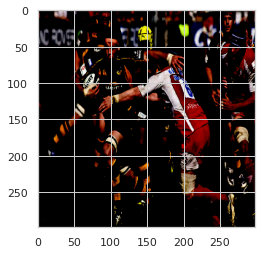

In [26]:
# Lets explore an image
print(cap_test[50])
print(" ".join(tokenizer.index_word[i] for i in cap_test[10]))
plt.imshow(load_image(path_test[10])[0])

---
<a id='52'></a>
### 5.2) Map image path to image feature

The objective is to load precomputed image features from disk and pair them with their corresponding captions. This is useful for preparing data for training or evaluating models that require features and captions as inputs.

#### Steps Performed:

1. **Prepare the Path to Feature File**:
   - `path_of_feature = img_name.decode("utf-8") + '.npy'` constructs the filename of the feature file by appending `.npy` to the image name. 
     - `img_name` is assumed to be a byte string, so `decode("utf-8")` converts it to a regular string.
   - `path_of_feature = os.path.join(OUTPUT_IMG_PATH, path_of_feature.split('/')[-1])` creates the full file path for loading the feature file. 
     - `path_of_feature.split('/')[-1]` extracts the filename from the path.

2. **Load the Image Features**:
   - `img_tensor = np.load(path_of_feature)` loads the image features from the `.npy` file into a NumPy array.

3. **Return Image Features and Caption**:
   - `return img_tensor, cap` returns the loaded image features and their corresponding caption.

In [27]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_name, cap):
    # Construct the path to the feature file
    path_of_feature = img_name.decode("utf-8") + '.npy'
    path_of_feature = os.path.join(OUTPUT_IMG_PATH, path_of_feature.split('/')[-1])
    
    # Load the image features from the .npy file
    img_tensor = np.load(path_of_feature)
    
    return img_tensor, cap

#### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

---
<a id='53'></a>
### 5.3) Builder function to create train and test dataset

The function creates a TensorFlow `tf.data.Dataset` for loading image features and their corresponding captions efficiently. The dataset is prepared for training or evaluation by batching, shuffling, and prefetching the data.

#### Steps Performed:

1. **Create Initial Dataset**:
   - `dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))` creates a TensorFlow `Dataset` from the provided image features and captions. Each element of the dataset is a tuple `(img, cap)`.

2. **Shuffle the Dataset**:
   - `dataset = dataset.shuffle(BUFFER_SIZE)` shuffles the dataset to ensure that the model sees the data in a random order. This helps in improving the generalization of the model.

3. **Map the Dataset**:
   - `dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)` applies the `map_func` to each element of the dataset.
     - `tf.numpy_function` is used to apply the `map_func`, which loads image features and pairs them with captions.
     - `num_parallel_calls=tf.data.experimental.AUTOTUNE` allows TensorFlow to automatically determine the optimal number of parallel calls for performance.

4. **Batch the Dataset**:
   - `dataset = dataset.batch(BATCH_SIZE)` batches the dataset into batches of size `BATCH_SIZE`. This is crucial for efficient training as it allows the model to process multiple examples at once.

5. **Prefetch the Dataset**:
   - `dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)` prefetches batches of data while the model is training on the current batch. This improves the efficiency of data loading by overlapping data preprocessing with model training.

6. **Return the Dataset**:
   - `return dataset` returns the prepared `tf.data.Dataset` ready for use in training or evaluation.

In [28]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(img_data, cap_data):
    # Create a TensorFlow dataset from image data and captions
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))
    
    # Shuffle the dataset
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    # Map the dataset to load features and captions using map_func
    dataset = dataset.map(
        lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    
    # Batch the dataset
    dataset = dataset.batch(BATCH_SIZE)
    
    # Prefetch the dataset
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

#### Generate dataset

In [29]:
# Generate training dataset
train_dataset = gen_dataset(path_train, cap_train)

# Generate testing dataset
test_dataset = gen_dataset(path_test, cap_test)

In [30]:
# Retrieve a sample batch from the training dataset
sample_img_batch, sample_cap_batch = next(iter(train_dataset))

# Print the shape of the image features batch
print(sample_img_batch.shape)  # Expected shape: (batch_size, 8*8, 2048)

# Print the shape of the captions batch
print(sample_cap_batch.shape)  # Expected shape: (batch_size, max_len)

(32, 64, 2048)
(32, 34)


---
---
<a id='6'></a>
## 6. Model Building
1. Set the parameters
2. Build Encoder model
3. Build Attention model
4. Build Decoder model

<a id='61'></a>
### 6.1) Set the parameters

In [31]:
# Define hyperparameters and dataset statistics
embedding_dim = 256  # Dimensionality of embedding vectors
units = 512  # Number of units in the RNN or LSTM layers
vocab_size = 5001  # Vocabulary size (top 5,000 words + 1 for <unk> token)

# Calculate the number of steps per epoch for training and testing
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

# Determine the shape of the image features
attention_features_shape = bf.shape[0]  # This should match batch size

---
<a id='62'></a>
### 6.2) Encoder model

The `Encoder` class defines a neural network model that processes image features to produce embeddings suitable for further processing, such as attention mechanisms in image captioning tasks.

#### Steps Performed:

1. **Class Definition**:
   - `class Encoder(keras.Model):` creates a custom model class inheriting from `keras.Model`. This allows the definition of a custom model architecture with TensorFlow's Keras API.

2. **Constructor Method (`__init__`)**:
   - `def __init__(self, embed_dim):` initializes the model with an embedding dimension `embed_dim`.
   - `super(Encoder, self).__init__()` calls the parent class constructor to properly initialize the base `keras.Model` class.
   - `self.dense = layers.Dense(embed_dim)` creates a Dense layer that transforms the input features into an embedding space of dimension `embed_dim`.

3. **Call Method**:
   - `def call(self, features):` defines the forward pass of the model. This method is called during training and inference.
   - `features = self.dense(features)` applies the Dense layer to the input `features`, converting them into embeddings of size `embed_dim`.
   - `features = tf.nn.relu(features)` applies the ReLU (Rectified Linear Unit) activation function to introduce non-linearity and ensure that the embeddings have non-negative values.

In [32]:
class Encoder(keras.Model):
    def __init__(self, embed_dim):
        """
        Initialize the Encoder model with a Dense layer.

        Parameters:
        - embed_dim (int): The dimensionality of the embedding space.
        """
        super(Encoder, self).__init__()
        # Define a Dense layer to transform image features into embeddings
        self.dense = layers.Dense(embed_dim)
        
    def call(self, features):
        """
        Forward pass of the Encoder model.

        Parameters:
        - features (tf.Tensor): Input tensor containing image features with shape (batch, 8*8, feature_dim).

        Returns:
        - tf.Tensor: Transformed features with shape (batch, 8*8, embed_dim).
        """
        # Apply Dense layer to transform features
        features = self.dense(features)  # Extract features from the image shape: (batch, 8*8, embed_dim)
        # Apply ReLU activation
        features = tf.nn.relu(features)
        return features

In [33]:
# Create an instance of the Encoder class with a specified embedding dimension
encoder = Encoder(embedding_dim)

---
<a id='63'></a>
### 6.3) Attention model

The `Attention_model` class defines a custom attention mechanism in TensorFlow/Keras. The purpose of this model is to compute attention weights and context vectors based on input features and hidden states, which is crucial for this task.

#### Steps Performed:

1. **Class Definition**:
   - `class Attention_model(keras.Model):` creates a custom Keras model for the attention mechanism.

2. **Constructor Method (`__init__`)**:
   - `def __init__(self, units):` initializes the attention model with a specified number of units.
   - `self.W1 = layers.Dense(units)` creates a Dense layer for processing the input features.
   - `self.W2 = layers.Dense(units)` creates a Dense layer for processing the hidden state.
   - `self.V = layers.Dense(1)` creates a Dense layer to compute the attention scores.

3. **Call Method (`call`)**:
   - `def call(self, features, hidden):` defines the forward pass of the attention model.
     - `hidden_with_time_axis = tf.expand_dims(hidden, 1)` expands the hidden state to match the dimensions of the features for broadcasting.
     - `score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))` computes the score for each feature vector.
     - `attention_weights = keras.activations.softmax(self.V(score), axis=1)` calculates the attention weights by applying the softmax function.
     - `context_vector = attention_weights * features` computes the context vector by applying the attention weights to the features.
     - `context_vector = tf.reduce_sum(context_vector, axis=1)` aggregates the context vectors to produce a single vector per batch.

In [34]:
class Attention_model(keras.Model):
    def __init__(self, units):
        """
        Initialize the Attention model with dense layers for attention mechanism.

        Parameters:
        - units (int): The number of units in the Dense layers.
        """
        super(Attention_model, self).__init__()
        # Dense layer for computing scores from features
        self.W1 = layers.Dense(units)
        # Dense layer for computing scores from hidden states
        self.W2 = layers.Dense(units)
        # Dense layer for computing the final attention scores
        self.V = layers.Dense(1)
        self.units = units

    def call(self, features, hidden):
        """
        Forward pass of the Attention model.

        Parameters:
        - features (tf.Tensor): Input features with shape (batch_size, 8*8, embedding_dim).
        - hidden (tf.Tensor): Hidden state with shape (batch_size, hidden_size).

        Returns:
        - context_vector (tf.Tensor): Context vector with shape (batch_size, embedding_dim).
        - attention_weights (tf.Tensor): Attention weights with shape (batch_size, 8*8, 1).
        """
        # Expand hidden state for broadcasting -> shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # Compute score function -> shape: (batch_size, 8*8, units)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # Compute attention weights -> shape: (batch_size, 8*8, 1)
        attention_weights = keras.activations.softmax(self.V(score), axis=1)
        # Compute context vector -> shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features
        # Aggregate context vector -> shape (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

---
<a id='64'></a>
### 6.4) Decoder model

The `Decoder` class implements the decoding component to generate captions for the given image. It incorporates an attention mechanism and uses a GRU (Gated Recurrent Unit) for sequence generation, outputting predictions and maintaining hidden states.

#### Steps Performed:

1. **Class Definition**:
   - `class Decoder(keras.Model):` creates a custom Keras model for decoding sequences with attention.

2. **Constructor Method (`__init__`)**:
   - `def __init__(self, embed_dim, units, vocab_size):` initializes the `Decoder` model with the following parameters:
     - `embed_dim`: Dimension of the embedding vectors.
     - `units`: Number of units in the GRU and attention layers.
     - `vocab_size`: Size of the vocabulary for output predictions.
   - `self.attention = Attention_model(self.units)` initializes the attention mechanism.
   - `self.embed = layers.Embedding(vocab_size, embed_dim, mask_zero=True)` creates an embedding layer to map token indices to dense vectors.
   - `self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')` initializes a GRU layer to process sequences.
   - `self.d1 = layers.Dense(self.units)` creates a Dense layer for processing the GRU output.
   - `self.d2 = layers.Dense(vocab_size)` creates a Dense layer to output the prediction logits for each vocabulary token.

3. **Call Method (`call`)**:
   - `def call(self, x, features, hidden):` defines the forward pass of the `Decoder` model:
     - `context_vector, attention_weights = self.attention(features, hidden)` computes the context vector and attention weights.
     - `embed = self.embed(x)` embeds the input token indices into dense vectors.
     - `embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)` concatenates the context vector with the embedded input, preparing it for the GRU.
     - `output, state = self.gru(embed)` processes the concatenated input with the GRU, producing output sequences and updated hidden states.
     - `output = self.d1(output)` applies the first Dense layer to the GRU output.
     - `output = tf.reshape(output, (-1, output.shape[2]))` reshapes the output to be suitable for the final Dense layer.
     - `output = self.d2(output)` applies the final Dense layer to produce logits for each vocabulary token.

4. **Initialization Method (`init_state`)**:
   - `def init_state(self, batch_size):` initializes the hidden state of the GRU with zeros.

In [35]:
class Decoder(keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        """
        Initialize the Decoder model with attention, embedding, GRU, and Dense layers.

        Parameters:
        - embed_dim (int): Dimension of the embedding vectors.
        - units (int): Number of units in the GRU and attention layers.
        - vocab_size (int): Size of the vocabulary for output predictions.
        """
        super(Decoder, self).__init__()
        # Initialize the Attention model with specified units
        self.attention = Attention_model(units)
        # Define the embedding layer to map token indices to dense vectors
        self.embed = layers.Embedding(vocab_size, embed_dim, mask_zero=True)
        # Define the GRU layer with return_sequences and return_state options
        self.gru = tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        # Define Dense layers for processing GRU output and producing final predictions
        self.d1 = layers.Dense(units)
        self.d2 = layers.Dense(vocab_size)
        self.units = units

    def call(self, x, features, hidden):
        """
        Forward pass of the Decoder model.

        Parameters:
        - x (tf.Tensor): Input tensor with token indices, shape (batch_size, 1).
        - features (tf.Tensor): Image features with shape (batch_size, 8*8, embedding_dim).
        - hidden (tf.Tensor): Hidden state from the previous time step with shape (batch_size, units).

        Returns:
        - output (tf.Tensor): Logits for each vocabulary token, shape (batch_size * max_length, vocab_size).
        - state (tf.Tensor): Updated hidden state with shape (batch_size, units).
        - attention_weights (tf.Tensor): Attention weights with shape (batch_size, 8*8, 1).
        """
        # Compute context vector and attention weights
        context_vector, attention_weights = self.attention(features, hidden)
        # Embed the input token indices -> shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate context vector with embedded input -> shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Process the concatenated input with the GRU -> shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        # Apply Dense layers to GRU output
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # -> shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # -> shape : (batch_size * max_length, vocab_size)

        return output, state, attention_weights
    
    def init_state(self, batch_size):
        """
        Initialize the hidden state with zeros.

        Parameters:
        - batch_size (int): Size of the batch.

        Returns:
        - tf.Tensor: Initial hidden state with shape (batch_size, units).
        """
        return tf.zeros((batch_size, self.units))

In [36]:
# Initialize the Decoder model with specified parameters
decoder = Decoder(embedding_dim, units, vocab_size)

#### Experiment the architecture with a sample batch of images

In [37]:
# Extract features from a batch of images using the Encoder
features = encoder(sample_img_batch)

# Initialize the hidden state for the Decoder. The batch size is derived from the caption batch size.
hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])

# Prepare the initial input for the Decoder, which is the start token for each sequence in the batch.
# The start token indicates the beginning of a sequence and is applied to all sequences in the batch.
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

# Pass the initial input (start token), image features, and initial hidden state to the Decoder.
# The Decoder generates predictions, updates the hidden state, and computes attention weights.
predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)

# Print the shapes of the outputs to verify their dimensions
print('Feature shape from Encoder: {}'.format(features.shape))  # Expected shape: (batch_size, 8*8, embed_dim)
print('Predictions shape from Decoder: {}'.format(predictions.shape))  # Expected shape: (batch_size, vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))  # Expected shape: (batch_size, 8*8, 1)

Feature shape from Encoder: (32, 64, 256)
Predictions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


---
---
<a id='7'></a>
## 7. Model training & optimization
1. Set the optimizer & loss object
2. Create checkpoint manager
3. Create training & testing step functions
4. Create loss function for the test dataset
5. Train and optimize the model

<a id='71'></a>
### 7.1) Set the optimizer & loss object

In [38]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define the loss object for calculating loss during training
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

The objective is to compute a loss value for a given set of real and predicted values, while ignoring padding values in the real values.

#### Steps Performed:

1. **Create a Mask for Padding Values**:
   - `mask = tf.math.logical_not(tf.math.equal(real, 0))` generates a mask that identifies which elements in `real` are not equal to 0 (padding values).

2. **Compute the Loss**:
   - `loss_ = loss_object(real, pred)` calculates the loss for each element using a predefined `loss_object`, which measures the difference between `real` and `pred`.

3. **Cast Mask to Match Loss Type**:
   - `mask = tf.cast(mask, dtype=loss_.dtype)` converts the mask to the same data type as `loss_` for element-wise multiplication.

4. **Apply the Mask to the Loss**:
   - `loss_ *= mask` multiplies the computed loss by the mask to ensure padding values are excluded from the loss computation.

5. **Compute the Mean Loss**:
   - `return tf.reduce_mean(loss_)` calculates the mean of the masked loss values to obtain the final loss value.

In [39]:
def loss_function(real, pred):
    # Create a mask to ignore the padding values in the captions
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    # Compute the loss for each element
    loss_ = loss_object(real, pred)
    
    # Cast mask to the same dtype as loss_ for element-wise multiplication
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # Apply the mask to the loss to ignore padding values
    loss_ *= mask
    
    # Compute the mean loss over all elements
    return tf.reduce_mean(loss_)

---
<a id='72'></a>
### 7.2) Create checkpoint manager

The objective is to set up and manage the saving and restoring of model checkpoints for training a neural network, using TensorFlow's checkpointing utilities.

#### Steps Performed:

1. **Create a Checkpoint Object**:
   - `ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)` initializes a `tf.train.Checkpoint` object, which tracks the state of the `encoder`, `decoder`, and `optimizer`. This allows these components to be saved and restored during training.

2. **Create a Checkpoint Manager**:
   - `ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=5)` sets up a `tf.train.CheckpointManager` to handle the saving and loading of checkpoints.
   - `CHECKPOINT_PATH` specifies the directory where the checkpoints will be saved.
   - `max_to_keep=5` limits the number of checkpoints to keep; older checkpoints beyond this number will be deleted to manage storage.

In [40]:
# Initialize the Checkpoint object with the model components and optimizer
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)

# Set up the Checkpoint Manager to handle saving and loading of checkpoints
ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=5)

The objective is to determine the starting epoch for training based on the most recent checkpoint available.

#### Steps Performed:

1. **Initialize Starting Epoch**:
   - `start_epoch = 0` sets the default starting epoch to 0, which is used if no checkpoints are found.

2. **Check for Latest Checkpoint**:
   - `if ckpt_manager.latest_checkpoint:` checks if there is a latest checkpoint available.

3. **Extract Epoch from Latest Checkpoint**:
   - `start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])` retrieves the epoch number from the filename of the latest checkpoint.
     - `ckpt_manager.latest_checkpoint` gives the path of the most recent checkpoint file.
     - `.split('-')[-1]` splits the filename by hyphens and takes the last part, which is expected to be the epoch number.
     - `int(...)` converts this part to an integer to set `start_epoch`.

In [41]:
# Initialize the starting epoch
start_epoch = 0

# Check if there is a latest checkpoint available
if ckpt_manager.latest_checkpoint:
    # Extract the epoch number from the filename of the latest checkpoint
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

---
<a id='73'></a>
### 7.3) Create training & testing step functions

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

The objective is to define a training step for a neural network model involving an encoder and a decoder, where the goal is to compute the loss and update the model parameters through backpropagation.

#### Steps Performed:

1. **Initialize Variables**:
   - `loss = 0` initializes the loss accumulator.
   - `hidden = decoder.init_state(batch_size=target.shape[0])` initializes the decoder's hidden state with the batch size.
   - `dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)` creates the initial input for the decoder, which is the `<start>` token for each sequence in the batch.

2. **Compute Predictions and Loss**:
   - `with tf.GradientTape() as tape:` starts recording operations for automatic differentiation.
   - `features = encoder(img_tensor)` extracts features from the input image using the encoder.
   - A `for` loop iterates through the sequence steps (excluding the first step, as it’s already initialized):
     - `predictions, hidden, _ = decoder(dec_input, features, hidden)` generates predictions and updates the hidden state using the decoder.
     - `loss += loss_function(target[:, i], predictions)` accumulates the loss computed for the current step.
     - `dec_input = tf.expand_dims(target[:, i], 1)` updates the input for the next step with the actual target value.

3. **Average Loss Calculation**:
   - `avg_loss = (loss / int(target.shape[1]))` computes the average loss by dividing the accumulated loss by the number of time steps.

4. **Apply Gradients**:
   - `trainable_variables = encoder.trainable_variables + decoder.trainable_variables` combines the trainable variables of both encoder and decoder.
   - `gradients = tape.gradient(loss, trainable_variables)` computes the gradients of the loss with respect to the trainable variables.
   - `optimizer.apply_gradients(zip(gradients, trainable_variables))` updates the model parameters using the computed gradients.

5. **Return Values**:
   - `return loss, avg_loss` returns the total loss and average loss for monitoring during training.

In [42]:
@tf.function
def train_step(img_tensor, target):
    # Initialize loss and hidden state
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    # Record operations for gradient computation
    with tf.GradientTape() as tape:
        # Get features from the encoder
        features = encoder(img_tensor)

        # Loop through each time step in the target sequence
        for i in range(1, target.shape[1]):
            # Get predictions and update hidden state from the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            # Accumulate loss for the current time step
            loss += loss_function(target[:, i], predictions)
            # Update decoder input for the next time step
            dec_input = tf.expand_dims(target[:, i], 1)
    
    # Compute the average loss over the sequence
    avg_loss = (loss / int(target.shape[1]))

    # Get all trainable variables and compute gradients
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    # Apply gradients to update model parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    # Return loss values for monitoring
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

The objective is to define a test step for evaluating the performance of a neural network model, specifically for generating predictions and computing the loss for a given set of input images and targets.

#### Steps Performed:

1. **Initialize Variables**:
   - `loss = 0` initializes the loss accumulator.
   - `hidden = decoder.init_state(batch_size=target.shape[0])` initializes the decoder's hidden state with the batch size.
   - `dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)` creates the initial input for the decoder, which is the `<start>` token for each sequence in the batch.

2. **Compute Features**:
   - `features = encoder(img_tensor)` extracts features from the input image using the encoder.

3. **Generate Predictions and Compute Loss**:
   - A `for` loop iterates through the sequence steps (excluding the first step, as it’s already initialized):
     - `predictions, hidden, attention_weights = decoder(dec_input, features, hidden)` generates predictions and updates the hidden state using the decoder. The attention weights are also computed but not used further in this snippet.
     - `loss += loss_function(target[:, i], predictions)` accumulates the loss computed for the current step.
     - `predicted_id = tf.argmax(predictions, 1)` selects the most probable word ID from the decoder's predictions.
     - `dec_input = tf.expand_dims(predicted_id, 1)` updates the input for the next step with the predicted word ID.

4. **Average Loss Calculation**:
   - `avg_loss = (loss / int(target.shape[1]))` computes the average loss by dividing the accumulated loss by the number of time steps.

5. **Return Values**:
   - `return loss, avg_loss` returns the total loss and average loss for evaluation purposes.

In [43]:
@tf.function
def test_step(img_tensor, target):
    # Initialize loss and hidden state
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    # Get features from the encoder
    features = encoder(img_tensor)

    # Loop through each time step in the target sequence
    for i in range(1, target.shape[1]):
        # Get predictions, update hidden state, and compute attention weights
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # Accumulate loss for the current time step
        loss += loss_function(target[:, i], predictions)

        # Get the predicted word ID for the next input
        predicted_id = tf.argmax(predictions, 1)
        dec_input = tf.expand_dims(predicted_id, 1)
        
    # Compute the average loss over the sequence
    avg_loss = (loss / int(target.shape[1]))
        
    # Return loss values for evaluation
    return loss, avg_loss

---
<a id='74'></a>
### 7.4) Create loss function for the test dataset

The objective is to compute the average loss over a test dataset, using the `test_step` function to evaluate the performance of a neural network model.

#### Steps Performed:

1. **Initialize Total Loss**:
   - `total_loss = 0` initializes the variable to accumulate the total loss across all batches.

2. **Iterate Over Test Dataset**:
   - `for (batch, (img_tensor, target)) in enumerate(test_dataset):` iterates through each batch of the test dataset.
     - `img_tensor` and `target` are the inputs and target outputs for the current batch.

3. **Compute Batch Loss**:
   - `batch_loss, t_loss = test_step(img_tensor, target)` computes the loss for the current batch using the `test_step` function.
   - `total_loss += t_loss` adds the batch loss to the total loss accumulator.

4. **Compute Average Test Loss**:
   - `avg_test_loss = total_loss / test_num_steps` calculates the average test loss by dividing the total loss by `test_num_steps`. Note: `test_num_steps` should be defined elsewhere in your code to represent the number of batches in the test dataset.

5. **Return Average Test Loss**:
   - `return avg_test_loss` returns the computed average test loss for evaluation purposes.

In [44]:
def test_loss_cal(test_dataset):
    total_loss = 0

    # Iterate over the test dataset
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        # Compute loss for the current batch
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss  # Accumulate total loss
    
    # Compute average test loss
    avg_test_loss = total_loss / test_num_steps  # Make sure test_num_steps is defined
    
    return avg_test_loss

---
<a id='75'></a>
### 7.5) Train and optimize the model

The objective is to train a neural network model for a specified number of epochs, track training and testing losses, and save the model checkpoint if the test loss improves.

#### Steps Performed:

1. **Initialize Variables**:
   - `loss_plot = []` initializes a list to store average training losses per epoch.
   - `test_loss_plot = []` initializes a list to store test losses per epoch.
   - `EPOCHS = 20` sets the number of epochs for training.
   - `best_test_loss = 100` initializes the best test loss to a high value to monitor improvement.
   - `early_stop_counter = 0` initializes a counter for early stopping.

2. **Training Loop**:
   - `for epoch in tqdm(range(0, EPOCHS)):` iterates through the epochs with a progress bar.
     - `start = time.time()` records the start time of the epoch.
     - `total_loss = 0` initializes the total loss for the current epoch.

3. **Batch Training**:
   - `for (batch, (img_tensor, target)) in enumerate(train_dataset):` iterates through each batch of the training dataset.
     - `batch_loss, t_loss = train_step(img_tensor, target)` computes the batch loss.
     - `total_loss += t_loss` accumulates the total loss for the epoch.
     - `avg_train_loss = total_loss / train_num_steps` calculates the average training loss.

4. **Test Loss Calculation**:
   - `test_loss = test_loss_cal(test_dataset)` computes the test loss on the test dataset.
   - `test_loss_plot.append(test_loss)` records the test loss for later analysis.

5. **Checkpoint Saving and Early Stopping**:
   - Compares the current test loss with `best_test_loss` to check for improvement.
     - If the test loss improves, it prints the reduction, updates `best_test_loss`, and saves a model checkpoint using `ckpt_manager.save()`.
     - Resets `early_stop_counter` if the test loss improves, otherwise increments it.
   - Training stops early if `early_stop_counter` exceeds 5, indicating no significant improvement in test loss for 5 consecutive epochs.

In [45]:
# Initialize lists to store training and test loss values for plotting
loss_plot = []
test_loss_plot = []

# Set the number of epochs for training
EPOCHS = 20

# Initialize the best test loss to a high value to ensure any improvement is captured
best_test_loss = 100  

# Initialize a counter for early stopping
early_stop_counter = 0

# Loop over the number of epochs
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()  # Record the start time of the current epoch
    total_loss = 0  # Initialize total loss for this epoch

    # Training loop: iterate over the training dataset
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        # Perform a training step and get the batch loss and total loss
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss  # Accumulate the total loss for the epoch
    
    # Compute average training loss for the epoch
    avg_train_loss = total_loss / train_num_steps
    # Append the average training loss to the loss plot list
    loss_plot.append(avg_train_loss)
    
    # Test loop: calculate the test loss using the test dataset
    test_loss = test_loss_cal(test_dataset)
    # Append the test loss to the test loss plot list
    test_loss_plot.append(test_loss)
    
    # Print the training and test loss for the current epoch
    print('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch + 1, avg_train_loss, test_loss))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    # Check if the test loss has improved (is lower than the best recorded test loss)
    if test_loss < best_test_loss:
        # If improved, print the improvement and update the best test loss
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        
        # Save the current model checkpoint
        ckpt_manager.save()
        
        # Reset the early stopping counter since there's an improvement
        early_stop_counter = 0
    else:
        # Increment the early stopping counter if there's no improvement
        early_stop_counter += 1
    
    # If there's no improvement for 5 consecutive epochs, stop training early
    if early_stop_counter >= 5:
        print('No progress in test loss for consecutive 5 epochs, hence stop training!')
        break

  0%|          | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.300, & test loss is 1.976
Time taken for 1 epoch 180.09244465827942 sec

Test loss has been reduced from 100.000 to 1.976


  5%|▌         | 1/20 [03:00<57:06, 180.36s/it]

For epoch: 2, the train loss is 1.049, & test loss is 1.903
Time taken for 1 epoch 94.44556474685669 sec

Test loss has been reduced from 1.976 to 1.903


 15%|█▌        | 3/20 [06:04<31:37, 111.60s/it]

For epoch: 3, the train loss is 0.957, & test loss is 1.967
Time taken for 1 epoch 89.74842762947083 sec



 20%|██        | 4/20 [07:35<27:35, 103.48s/it]

For epoch: 4, the train loss is 0.892, & test loss is 1.934
Time taken for 1 epoch 91.0290880203247 sec



 25%|██▌       | 5/20 [09:10<25:07, 100.48s/it]

For epoch: 5, the train loss is 0.836, & test loss is 1.941
Time taken for 1 epoch 95.13908672332764 sec



 30%|███       | 6/20 [10:42<22:44, 97.45s/it] 

For epoch: 6, the train loss is 0.787, & test loss is 2.014
Time taken for 1 epoch 91.55817747116089 sec



 30%|███       | 6/20 [12:16<28:39, 122.79s/it]

For epoch: 7, the train loss is 0.741, & test loss is 2.035
Time taken for 1 epoch 94.22305345535278 sec

No progress in test loss for consecutive 5 epochs, hence stop training!


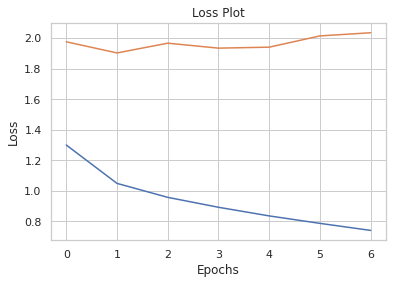

In [46]:
plt.plot(loss_plot)  # Plot average training loss
plt.plot(test_loss_plot)  # Plot test loss
plt.xlabel('Epochs')  # Label x-axis
plt.ylabel('Loss')  # Label y-axis
plt.title('Loss Plot')  # Set plot title
plt.show()  # Display the plot

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

---
---
<a id='8'></a>
## 8. Model Evaluation
1. Define evaluation function using greedy search
2. Define evaluation function using beam search
3. Test it on a sample test data using BLEU score
4. Test it on unseen sample data

<a id='81'></a>
### 8.1) Greedy Search

The objective is to perform a greedy decoding evaluation of an image using a trained neural network model, which involves generating a caption for the image and visualizing the attention weights.

#### Steps Performed:

1. **Initialize Variables**:
   - `attention_plot = np.zeros((max_length, attention_features_shape))` initializes an array to store the attention weights for each time step.

2. **Prepare Image and Extract Features**:
   - `hidden = decoder.init_state(batch_size=1)` initializes the decoder’s hidden state for a single batch.
   - `temp_input = tf.expand_dims(load_image(image)[0], 0)` processes the input image to the required format for feature extraction.
   - `img_tensor_val = image_features_extract_model(temp_input)` extracts features from the image using the feature extraction model.
   - `img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))` reshapes the features for the encoder.

3. **Extract Features**:
   - `features = encoder(img_tensor_val)` extracts features from the image by passing the reshaped features through the encoder.

4. **Generate Caption**:
   - `dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)` initializes the decoder input with the `<start>` token.
   - `result = []` initializes a list to store the generated words.

5. **Decoding Loop**:
   - A `for` loop iterates up to `max_length`:
     - `predictions, hidden, attention_weights = decoder(dec_input, features, hidden)` generates predictions and attention weights from the decoder.
     - `attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()` stores the attention weights for the current step.
     - `predicted_id = tf.argmax(predictions[0]).numpy()` retrieves the word ID with the highest probability.
     - `result.append(tokenizer.index_word[predicted_id])` maps the ID to a word and adds it to the result list.
     - If the `<end>` token is predicted, the function returns the generated result, attention plot, and predictions.
     - `dec_input = tf.expand_dims([predicted_id], 0)` updates the decoder input for the next time step.

6. **Return Results**:
   - `attention_plot = attention_plot[:len(result), :]` trims the attention plot to the length of the generated result.
   - `return result, attention_plot, predictions` returns the generated caption, attention weights, and predictions.

In [47]:
def greedy_evaluate(image):
    # Initialize an array to store attention weights
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Initialize decoder hidden state
    hidden = decoder.init_state(batch_size=1)

    # Process the input image and extract features
    temp_input = tf.expand_dims(load_image(image)[0], 0)  # Preprocess the image
    img_tensor_val = image_features_extract_model(temp_input)  # Extract features
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Extract features using encoder
    features = encoder(img_tensor_val)

    # Initialize decoder input with <start> token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    result = []
    # Generate caption
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)  # Decode
        
        # Store attention weights
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Get predicted word ID and map to word
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        # Check if <end> token is predicted
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        # Update decoder input for next time step
        dec_input = tf.expand_dims([predicted_id], 0)

    # Trim attention plot to length of result
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

---
<a id='82'></a>
### 8.2) Beam Search

The objective is to generate a caption for an image using the beam search decoding method, which helps in selecting the most likely caption sequence by considering multiple possible sequences and their associated probabilities.

#### Steps Performed:

1. **Initialize Start Token and Result List**:
   - The captioning process starts with the `<start>` token. The `result` list is initialized with this token and a probability of `0.0`, indicating the start of the sequence.

2. **Set Up Attention Plot**:
   - `attention_plot` is initialized as a zero matrix to store the attention weights for each word in the caption. These weights will be used to visualize which parts of the image the model focused on while generating each word.

3. **Prepare Image Features**:
   - The input image is loaded and processed using a pre-trained model (`image_features_extract_model`) to extract its features. These features are then passed through an encoder to prepare them for the decoder.

4. **Caption Generation Loop**:
   - The loop continues until the generated caption reaches the maximum length (`max_length`) or the `<end>` token is encountered.
   - For each partial caption in the `result` list:
     - The decoder predicts the next word using the current state, image features, and the previous word.
     - The attention weights are stored for later visualization.
     - The top `beam_index` predictions (words with the highest probabilities) are selected.
     - Each selected word is appended to the current caption, and the cumulative log probability is updated.
   - The partial captions are sorted by their probabilities, and only the top `beam_index` captions are kept for further expansion.

5. **Select Final Caption**:
   - The final caption is selected as the one with the highest cumulative probability.
   - The `<start>` and `<end>` tokens are removed from the final caption, leaving the meaningful words.
   - The `attention_plot` is trimmed to match the length of the generated caption, and both the caption and attention plot are returned for further use.

In [48]:
def beam_evaluate(image, beam_index=3):
    # Start caption generation with the '<start>' token
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]  # Initialize result list with the start token and zero probability

    # Initialize the attention plot to store attention weights for visualization
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Initialize the hidden state of the decoder
    hidden = decoder.init_state(batch_size=1)

    # Load and process the image to extract its features
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Encode the image features
    features = encoder(img_tensor_val)

    # Initialize the decoder input with the '<start>' token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    # Loop until the caption reaches the maximum length or the '<end>' token is generated
    while len(result[0][0]) < max_length:
        i = 0
        temp = []
        for s in result:
            # Predict the next word using the decoder
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()  # Store attention weights
            i += 1
            
            # Get the top beam_index predictions
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)  # Append the predicted word to the current caption
                prob += np.log(predictions[0][w])  # Update cumulative log probability
                temp.append([next_cap, prob])

        # Sort and select the top beam_index captions
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]

        # Update the decoder input with the last predicted word
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        prd_id = pred_list[-1]
        if prd_id != tokenizer.word_index['<end>']:  # If the predicted word is not '<end>'
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break

    # Generate the final caption from the best result
    result2 = result[-1][0]
    final_caption = [tokenizer.index_word[i] for i in result2]

    # Trim the attention plot to the length of the generated caption
    attention_plot = attention_plot[:len(final_caption), :]
    
    # Return the final caption, attention plot, and predictions
    return final_caption, attention_plot, predictions

---
<a id='83'></a>
### 8.3) Helper methods for evaluation

#### A) plot_attmap():

The objective of this function is to visualize the attention maps overlaid on the input image, along with the generated captions.

#### Steps Performed:

1. **Initialize Plot**:
   - `fig = plt.figure(figsize=(10, 10))` creates a new figure with a size of 10x10 inches for plotting.

2. **Load Image**:
   - `temp_img = np.array(Image.open(image))` loads the input image and converts it to a NumPy array.

3. **Plot Attention Maps**:
   - `len_cap = len(caption)` determines the number of captions (and thus the number of attention maps).
   - A `for` loop iterates over each caption and its corresponding attention weights:
     - `weights_img = np.reshape(weights[cap], (8, 8))` reshapes the attention weights to an 8x8 grid.
     - `weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))` resizes the attention weights image to match the size of the input image (224x224).
     - `ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)` creates a subplot for each caption and attention map.
     - `ax.set_title(caption[cap], fontsize=15)` sets the title of the subplot to the caption text.
     - `img = ax.imshow(temp_img)` displays the input image in the subplot.
     - `ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())` overlays the attention map on top of the input image using a heatmap colormap (`gist_heat`) with 60% opacity.
     - `ax.axis('off')` hides the axes for a cleaner visualization.

4. **Adjust Layout and Display**:
   - `plt.subplots_adjust(hspace=0.2, wspace=0.2)` adjusts the spacing between subplots.
   - `plt.show()` displays the figure.

In [49]:
def plot_attmap(caption, weights, image):
    # Initialize the figure for plotting
    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))  # Load the input image as a NumPy array

    len_cap = len(caption)  # Number of captions (and attention maps)
    for cap in range(len_cap):
        # Reshape and resize the attention weights for visualization
        weights_img = np.reshape(weights[cap], (8, 8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        # Create a subplot for each caption and attention map
        ax = fig.add_subplot(len_cap // 2, len_cap // 2, cap + 1)
        ax.set_title(caption[cap], fontsize=15)  # Set the caption text as the subplot title

        # Display the input image and overlay the attention map
        img = ax.imshow(temp_img)
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
        ax.axis('off')  # Hide the axes for cleaner visualization

    # Adjust layout and display the plot
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.suptitle('Captions generated by Attention model')
    plt.show()

#### B) filt_text():

The objective of this function is to filter out specific tokens (e.g., `<start>`, `<unk>`, `<end>`) from a given text string.

#### Steps Performed:

1. **Define Tokens to Filter**:
   - `filt=['<start>','<unk>','<end>']` defines a list of tokens to be removed from the text.

2. **Split Text**:
   - `temp = text.split()` splits the input text into a list of words or tokens.

3. **Remove Tokens**:
   - `[temp.remove(j) for k in filt for j in temp if k == j]` iterates over each token in `filt` and removes it from the `temp` list if it is present.

4. **Reconstruct Text**:
   - `text = ' '.join(temp)` joins the remaining tokens back into a single string.

5. **Return Filtered Text**:
   - `return text` returns the modified text with the specified tokens removed.

In [50]:
def filt_text(text):
    # Define tokens to filter out
    filt = ['<start>', '<unk>', '<end>']
    temp = text.split()  # Split text into a list of tokens
    
    # Remove tokens that are in the filter list
    [temp.remove(j) for k in filt for j in temp if k == j]
    
    # Reconstruct the text from the remaining tokens
    text = ' '.join(temp)
    
    return text

#### C) generate_caption_for_known_test_data():

The function generates and evaluates a caption for a given image using either greedy or beam search decoding. It also converts the caption into speech.

#### Steps Performed:

1. **Display Original Image**:
   - Print and display the original image with `plt.imshow()`.

2. **Print Real Caption**:
   - Construct the real caption from token IDs, filter out unwanted tokens, and print it.

3. **Generate and Print Predicted Caption**:
   - Depending on the specified evaluation method (`GREEDY_EVALUATE` or `BEAM_EVALUATE`), calls the corresponding function (`greedy_evaluate` or `beam_evaluate`) to generate the caption for the image.
   - Print the predicted caption.

4. **Calculate and Print BLEU Scores**:
   - Compute BLEU scores for different n-gram weights to evaluate the quality of the predicted caption compared to the real caption.
   - Print the BLEU scores.

5. **Plot Attention Maps**:
   - Plot attention maps along with the image to visualize how different parts of the image influence the generated caption.

6. **Convert Text to Speech**:
   - Convert the predicted caption to an audio file using the `gTTS` library and save it as an MP3 file.

In [51]:
# Set indices to use the evaluation method
GREEDY_EVALUATE = 1
BEAM_EVALUATE   = 2

In [52]:
# Function for predicting caption and convert to audio on known sample test data
def generate_caption_for_known_test_data(input_image, real_caption_tokens, evaluate=GREEDY_EVALUATE):    
    """
    Generates a caption for a given image, evaluates it using the specified method, and converts the caption to speech.
    
    Parameters:
    - input_image: Path to the image file for which to generate a caption.
    - evaluate: Method to use for generating captions. Options are:
      - GREEDY_EVALUATE (1): Uses greedy search for decoding.
      - BEAM_EVALUATE (2): Uses beam search for decoding.
    """
    
    # Display the original image
    plt.imshow(mpimg.imread(input_image), interpolation='nearest', aspect='auto')
    Image.open(input_image)
    plt.title('Original image')
    plt.grid(None)
    print("#" * 100)
    
    # Print the real caption
    real_caption = ' '.join([tokenizer.index_word[i] for i in real_caption_tokens if i not in [0]])
    real_caption = filt_text(real_caption)
    print('Real Caption:\n', real_caption)
    print("#" * 100)
    
    # Predict the caption based on the requested evaluation method
    if evaluate == GREEDY_EVALUATE:
        result, attention_plot, pred_test = greedy_evaluate(input_image)
    elif evaluate == BEAM_EVALUATE:
        result, attention_plot, pred_test = beam_evaluate(input_image)
    else:
        print('\n\n!!! Select a proper evaluation method to generate the captions !!!\n\n')
        return

    # Process and print the predicted caption
    pred_caption = ' '.join(result).rsplit(' ', 1)[0]
    pred_caption = filt_text(pred_caption)
    print('Prediction Caption:\n', pred_caption)
    print("#" * 100)
    
    # Calculate BLEU scores for different n-gram weights
    real_appn = [real_caption.split()]
    reference = real_appn
    candidate = pred_caption.split()
    
    print('BLEU score 1-gram: %.2f' % (100.0 * sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))))
    print('BLEU score 2-gram: %.2f' % (100.0 * sentence_bleu(reference, candidate, weights=(.5, .5, 0, 0))))
    print('BLEU score 3-gram: %.2f' % (100.0 * sentence_bleu(reference, candidate, weights=(.33, .33, .33, 0))))
    print('BLEU score 4-gram: %.2f' % (100.0 * sentence_bleu(reference, candidate, weights=(.25, .25, .25, .25))))
    print("#" * 100)
    
    if evaluate == GREEDY_EVALUATE:
        # Plot attention maps along with captions and images
        plot_attmap(result, attention_plot, input_image)
        print("#" * 100)

    # Convert the predicted caption to speech and save the audio file
    print('\nAudio for the predicted caption:\n')
    language = 'en'
    txt_spch = gTTS(text=pred_caption, lang=language, slow=False)
    
    # Generate a file name based on the caption
    caption_filename = '_'.join(pred_caption.split()[:5]) + '.mp3'  # Use first 5 words for filename
    txt_spch_file_path = os.path.join(CAPTION_AUDIO_PATH, caption_filename)
    
    # Save the audio file
    txt_spch.save(txt_spch_file_path)
    
    # Display the audio player (for Jupyter Notebooks)
    audio = Audio(txt_spch_file_path)
    display(audio)

#### D) generate_caption_for_unknown_data():

This function generates a caption for an unknown image and optionally provide debugging information like visualizing attention maps if requested.

#### Steps Performed:

1. **Display Original Image**:
   - Uses `plt.imshow()` and `Image.open()` to display the original image for visual inspection.
   - Sets the title of the image and removes grid lines for a cleaner look.

2. **Generate Predicted Caption**:
   - Depending on the specified evaluation method (`GREEDY_EVALUATE` or `BEAM_EVALUATE`), calls the corresponding function (`greedy_evaluate` or `beam_evaluate`) to generate the caption for the image.
   - Formats the predicted caption by joining the result and removing the last token if necessary.

3. **Print Predicted Caption**:
   - Outputs the generated caption to the console.

4. **Optional Debugging**:
   - If `debug` is `True`, visualize the attention maps for the generated caption using `plot_attmap()`.

In [53]:
# Function for predicting caption and convert to audio on unknown data
def generate_caption_for_unknown_data(input_image, evaluate=GREEDY_EVALUATE, debug=False):
    """
    Generates a caption for an unknown image and displays it. Also provides optional debugging information.

    Parameters:
    - input_image: Path to the image file for which to generate a caption.
    - evaluate: Method to use for generating captions. Options are:
      - GREEDY_EVALUATE (1): Uses greedy search for decoding.
      - BEAM_EVALUATE (2): Uses beam search for decoding.
    - debug: Boolean flag to enable or disable debugging information (default is False).
    """
    
    # Display the original image
    plt.imshow(mpimg.imread(input_image), interpolation='nearest', aspect='auto')
    Image.open(input_image)
    plt.title('Original image')
    plt.grid(None)
    print("#" * 100)
    
    # Predict the caption based on the evaluation method
    if evaluate == GREEDY_EVALUATE:
        result, attention_plot, pred_test = greedy_evaluate(input_image)
    elif evaluate == BEAM_EVALUATE:
        result, attention_plot, pred_test = beam_evaluate(input_image)
    else:
        print('\n\n!!! Select a proper evaluation method to generate the captions !!!\n\n')
        print("#" * 100)
        return
    
    # Process and print the predicted caption
    pred_caption = ' '.join(result).rsplit(' ', 1)[0]
    pred_caption = filt_text(pred_caption)
    print('Predicted Caption:\n', pred_caption)
    print("#" * 100)
    
    # Optionally plot attention maps
    if debug:
        plot_attmap(result, attention_plot, input_image)
        print("#" * 100)

    # Convert the predicted caption to speech and save the audio file
    print('Audio for the predicted caption:\n')
    language = 'en'
    txt_spch = gTTS(text=pred_caption, lang=language, slow=False)
    
    # Generate a file name based on the caption
    caption_filename = '_'.join(pred_caption.split()[:5]) + '.mp3'  # Use first 5 words for filename
    txt_spch_file_path = os.path.join(CAPTION_AUDIO_PATH, caption_filename)
    
    # Save the audio file
    txt_spch.save(txt_spch_file_path)
    
    # Display the audio player (for Jupyter Notebooks)
    audio = Audio(txt_spch_file_path)
    display(audio)
    print("#" * 100)

---
<a id='84'></a>
### 8.4) Test on sample test data

The function selects a random image from the test dataset and generates a caption for it using the specified evaluation method. It then displays the results using the `generate_caption_for_known_test_data` function.

#### Steps Performed:

1. **Select Random Image**:
   - `rid = np.random.randint(0, len(path_test))` generates a random index to select an image from the test dataset.
   - `test_image = path_test[rid]` retrieves the path of the randomly selected test image.

2. **Generate and Display Caption**:
   - `generate_caption_for_known_test_data(test_image, evaluate)` calls the previously defined function to generate and evaluate the caption for the selected image.

In [54]:
def generate_caption_on_random_test_image(evaluate=GREEDY_EVALUATE):
    """
    Selects a random image from the test dataset and generates a caption for it using the specified evaluation method.
    
    Parameters:
    - evaluate: The evaluation method to use for generating captions. Options are:
      - GREEDY_EVALUATE (1): Uses greedy search for decoding.
      - BEAM_EVALUATE (2)  : Uses beam search for decoding.
    """
    
    # Select a random index from the range of the test dataset
    rid = np.random.randint(0, len(path_test))
    
    # Retrieve the path of the randomly selected test image
    test_image = path_test[rid]
    
    # Retrieve the tokens for the original caption corresponding to the selected image
    real_captions_token = cap_test[rid]
    
    # Generate and display the caption for the selected image using the specified evaluation method
    generate_caption_for_known_test_data(test_image, real_captions_token, evaluate)

#### A) Using Greedy evaluate

####################################################################################################
Real Caption:
 four people sit around campfire and the sky is blue behind them
####################################################################################################
Prediction Caption:
 several people sit around campfire
####################################################################################################
BLEU score 1-gram: 19.73
BLEU score 2-gram: 19.10
BLEU score 3-gram: 18.22
BLEU score 4-gram: 16.49
####################################################################################################


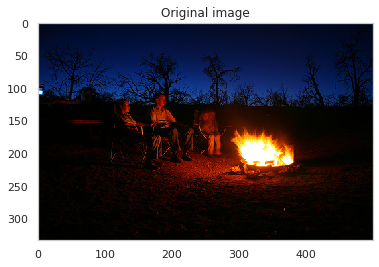

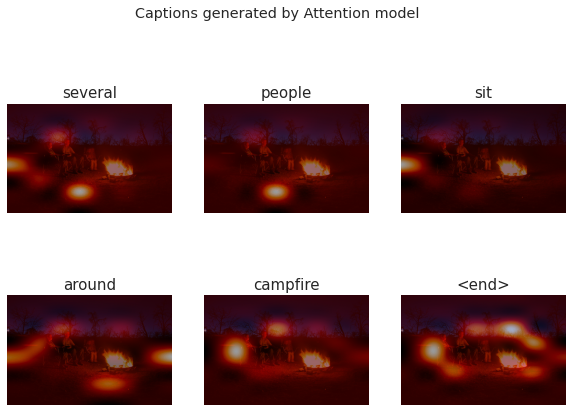

####################################################################################################

Audio for the predicted caption:



In [66]:
# Test on random image using greedy search
generate_caption_on_random_test_image(evaluate=GREEDY_EVALUATE)

**Inference:** Though the BLEU score is less, the caption certainly depicts the picture.

####################################################################################################
Real Caption:
 little girl plays in ball pit
####################################################################################################
Prediction Caption:
 the little girl is playing with balls
####################################################################################################
BLEU score 1-gram: 28.57
BLEU score 2-gram: 21.82
BLEU score 3-gram: 0.00
BLEU score 4-gram: 0.00
####################################################################################################


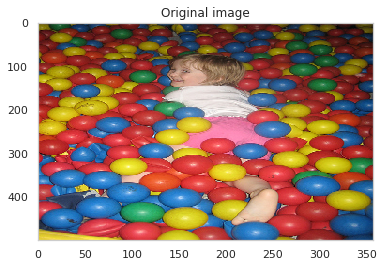

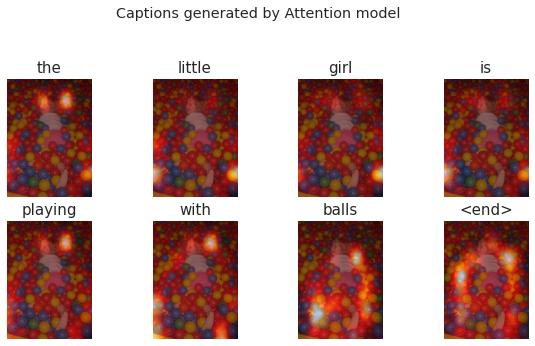

####################################################################################################

Audio for the predicted caption:



In [56]:
# Test on random image using greedy search
generate_caption_on_random_test_image(evaluate=GREEDY_EVALUATE)

**Inference:** Though the BLEU score is less, the caption certainly depicts the picture.

####################################################################################################
Real Caption:
 man wearing camo pants and grey jacket snowboarding near wooded area
####################################################################################################
Prediction Caption:
 the snowboarder is making jump in the air
####################################################################################################
BLEU score 1-gram: 0.00
BLEU score 2-gram: 0.00
BLEU score 3-gram: 0.00
BLEU score 4-gram: 0.00
####################################################################################################


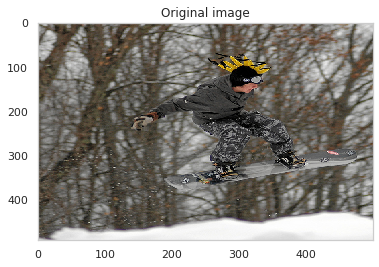

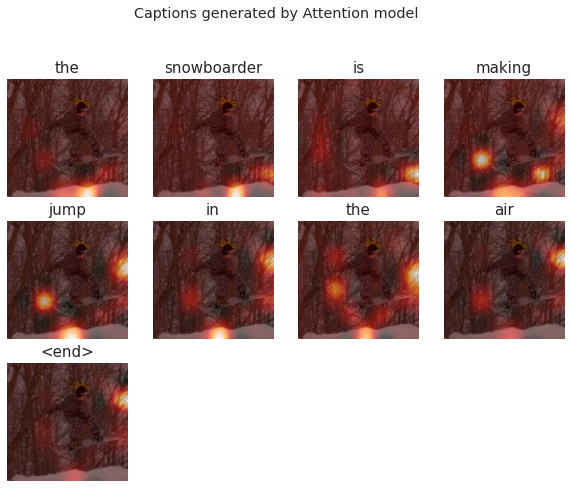

####################################################################################################

Audio for the predicted caption:



In [58]:
# Test on random image using greedy search
generate_caption_on_random_test_image(evaluate=GREEDY_EVALUATE)

**Inference:** Though the BLEU score is 0, the caption certainly depicts the person's action in the picture.

####################################################################################################
Real Caption:
 dog is shaking water off of itself
####################################################################################################
Prediction Caption:
 dog is shaking off water
####################################################################################################
BLEU score 1-gram: 67.03
BLEU score 2-gram: 47.40
BLEU score 3-gram: 37.11
BLEU score 4-gram: 0.00
####################################################################################################


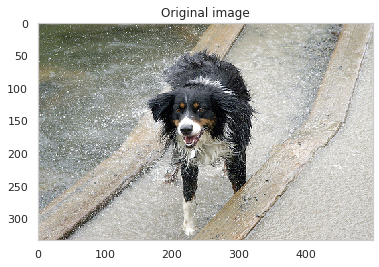

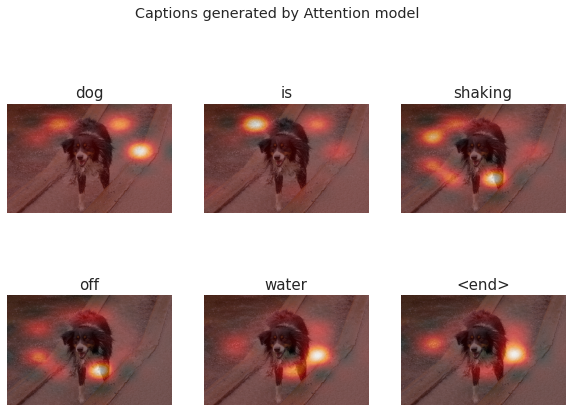

####################################################################################################

Audio for the predicted caption:



In [74]:
# Test on random image using greedy search
generate_caption_on_random_test_image(evaluate=GREEDY_EVALUATE)

**Inference:** The BLEU score is also high and the caption also certainly depicts the picture.

####################################################################################################
Real Caption:
 basketball player jumps for shot while another attempts to block him
####################################################################################################
Prediction Caption:
 the basketball player is trying to block him
####################################################################################################
BLEU score 1-gram: 42.96
BLEU score 2-gram: 35.57
BLEU score 3-gram: 24.64
BLEU score 4-gram: 0.00
####################################################################################################


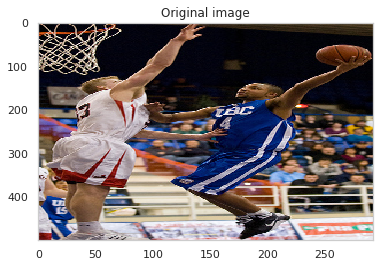

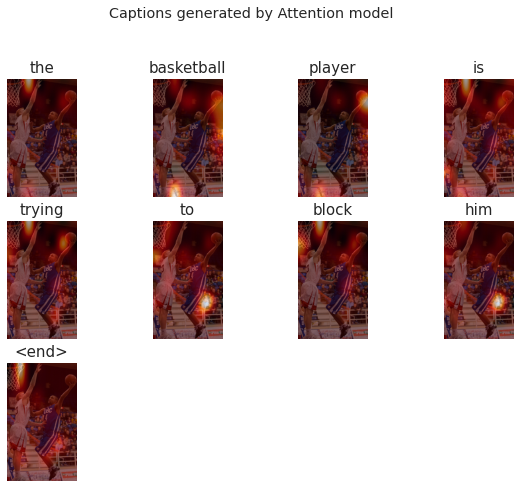

####################################################################################################

Audio for the predicted caption:



In [84]:
# Test on random image using greedy search
generate_caption_on_random_test_image(evaluate=GREEDY_EVALUATE)

**Inference:** The BLEU score is decent and the caption certainly depicts one of the person's action in the picture.

---
#### B) Using Beam evaluate

####################################################################################################
Real Caption:
 snowboarder jumps off an old snowcovered building
####################################################################################################
Prediction Caption:
 snowboarder on jumping over snow covered wall
####################################################################################################
BLEU score 1-gram: 14.29
BLEU score 2-gram: 0.00
BLEU score 3-gram: 0.00
BLEU score 4-gram: 0.00
####################################################################################################

Audio for the predicted caption:



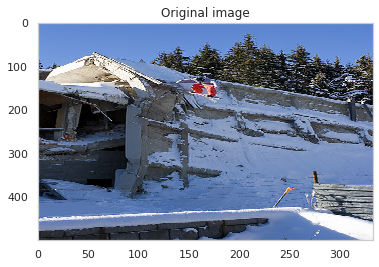

In [90]:
# Test on random image using beam search
generate_caption_on_random_test_image(evaluate=BEAM_EVALUATE)

**Inference:** Though the BLEU score is less, the caption certainly depicts person's action in the picture.

####################################################################################################
Real Caption:
 the boy is jumping into the swimming pool
####################################################################################################
Prediction Caption:
 boy jumping into pool
####################################################################################################
BLEU score 1-gram: 36.79
BLEU score 2-gram: 21.24
BLEU score 3-gram: 0.00
BLEU score 4-gram: 0.00
####################################################################################################

Audio for the predicted caption:



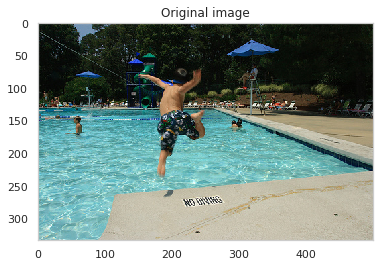

In [112]:
# Test on random image using beam search
generate_caption_on_random_test_image(evaluate=BEAM_EVALUATE)

**Inference:** The BLEU score is decent and the caption certainly depicts person's action in the picture.

####################################################################################################
Real Caption:
 man wearing kilt is playing the bagpipes
####################################################################################################
Prediction Caption:
 man wearing hat and tie holding bagpipes
####################################################################################################
BLEU score 1-gram: 42.86
BLEU score 2-gram: 26.73
BLEU score 3-gram: 0.00
BLEU score 4-gram: 0.00
####################################################################################################

Audio for the predicted caption:



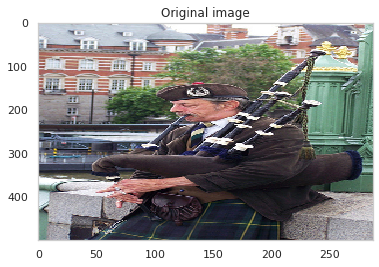

In [114]:
# Test on random image using beam search
generate_caption_on_random_test_image(evaluate=BEAM_EVALUATE)

**Inference:** The BLEU score is decent and the caption certainly depicts the picture.

####################################################################################################
Real Caption:
 two skiers one in pink and one in black ride on ski lift
####################################################################################################
Prediction Caption:
 two people are on ski lift
####################################################################################################
BLEU score 1-gram: 20.76
BLEU score 2-gram: 16.08
BLEU score 3-gram: 12.74
BLEU score 4-gram: 0.00
####################################################################################################

Audio for the predicted caption:



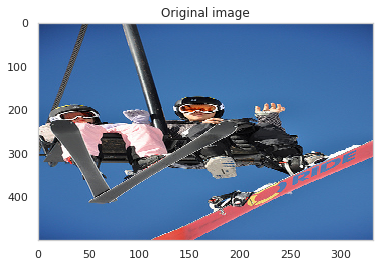

In [119]:
# Test on random image using beam search
generate_caption_on_random_test_image(evaluate=BEAM_EVALUATE)

**Inference:** Though the BLEU score is less, the caption certainly depicts the picture.

####################################################################################################
Real Caption:
 child in blue jacket and helmet is on skateboard
####################################################################################################
Prediction Caption:
 boy skateboards
####################################################################################################
BLEU score 1-gram: 0.00
BLEU score 2-gram: 0.00
BLEU score 3-gram: 0.00
BLEU score 4-gram: 0.00
####################################################################################################

Audio for the predicted caption:



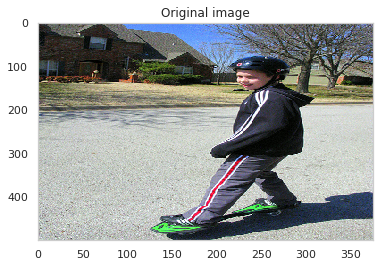

In [130]:
# Test on random image using beam search
generate_caption_on_random_test_image(evaluate=BEAM_EVALUATE)

**Inference:** Though the BLEU score is 0, the caption certainly depicts boy's action in the picture.

---
---
<a id='9'></a>
## 9. Experiment on unseen data

#### A man surfing

####################################################################################################
Predicted Caption:
 the surfer riding on wave
####################################################################################################


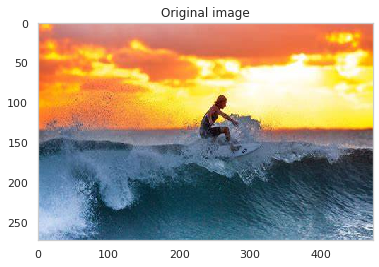

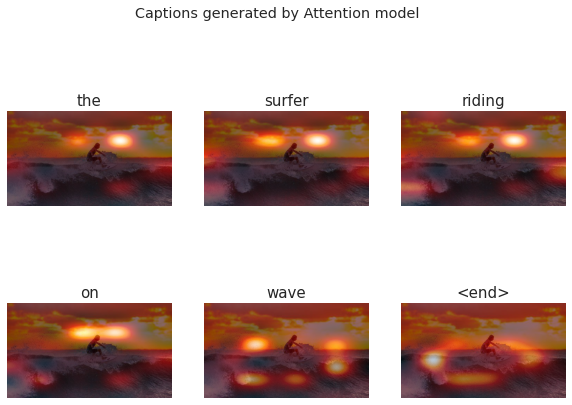

####################################################################################################
Audio for the predicted caption:



####################################################################################################


In [158]:
generate_caption_for_unknown_data('/home/EyeForBlind/unknown_data/surfing.jpeg', evaluate=GREEDY_EVALUATE, debug=True)

####################################################################################################
Predicted Caption:
 the ocean
####################################################################################################
Audio for the predicted caption:



####################################################################################################


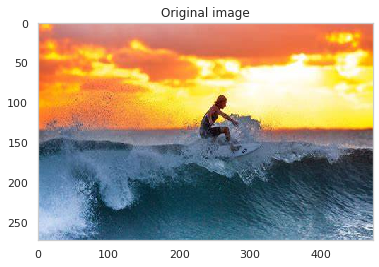

In [159]:
generate_caption_for_unknown_data('/home/EyeForBlind/unknown_data/surfing.jpeg', evaluate=BEAM_EVALUATE)

---
#### Dog running with a stick

####################################################################################################
Predicted Caption:
 dog is running through the grass
####################################################################################################


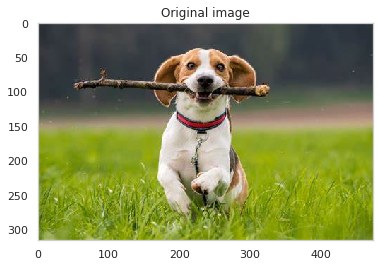

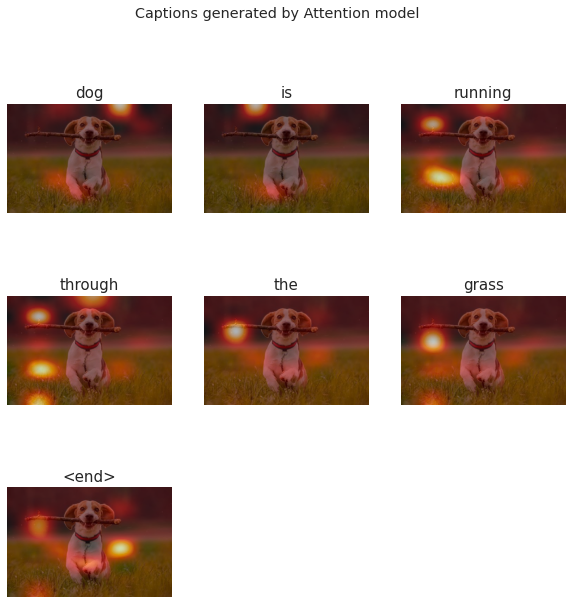

####################################################################################################
Audio for the predicted caption:



####################################################################################################


In [154]:
generate_caption_for_unknown_data('/home/EyeForBlind/unknown_data/dog_stick.jpeg', evaluate=GREEDY_EVALUATE, debug=True)

####################################################################################################
Predicted Caption:
 brown is running from the grass
####################################################################################################
Audio for the predicted caption:



####################################################################################################


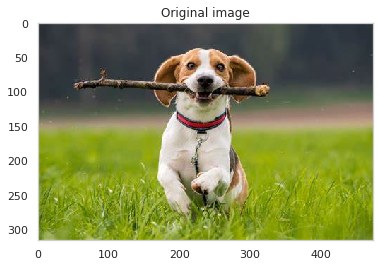

In [153]:
generate_caption_for_unknown_data('/home/EyeForBlind/unknown_data/dog_stick.jpeg', evaluate=BEAM_EVALUATE)

---

#### Boy driving a bicycle

####################################################################################################
Predicted Caption:
 boy riding bike
####################################################################################################


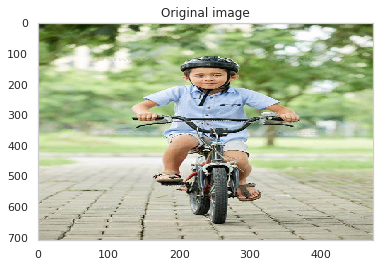

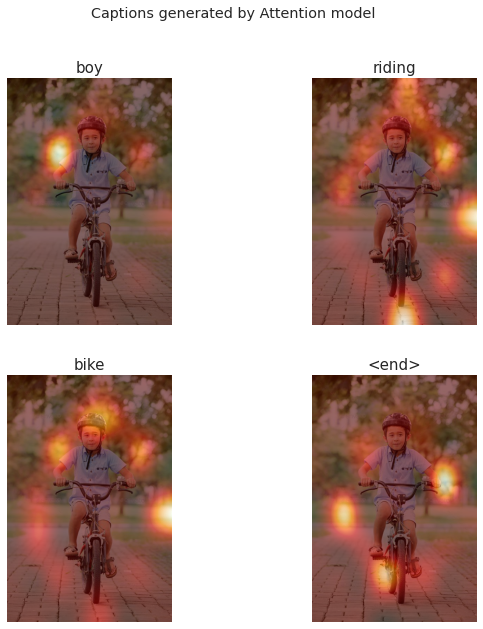

####################################################################################################
Audio for the predicted caption:



####################################################################################################


In [138]:
generate_caption_for_unknown_data('/home/EyeForBlind/unknown_data/boy_cycle.jpeg', evaluate=GREEDY_EVALUATE, debug=True)

####################################################################################################
Predicted Caption:
 boy riding bike
####################################################################################################
Audio for the predicted caption:



####################################################################################################


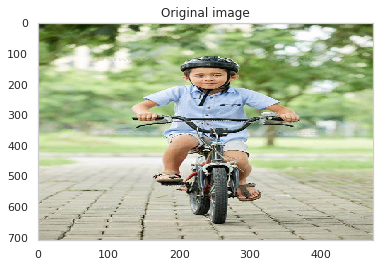

In [140]:
generate_caption_for_unknown_data('/home/EyeForBlind/unknown_data/boy_cycle.jpeg', evaluate=BEAM_EVALUATE)

---
#### Dogs running

####################################################################################################
Predicted Caption:
 dog runs along path
####################################################################################################
Audio for the predicted caption:



####################################################################################################


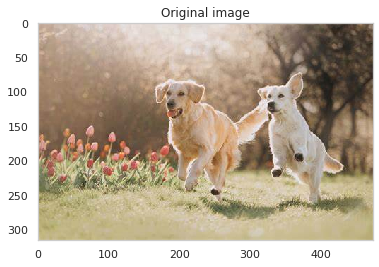

In [145]:
generate_caption_for_unknown_data('/home/EyeForBlind/unknown_data/dogs.jpeg', evaluate=GREEDY_EVALUATE)

####################################################################################################
Predicted Caption:
 yellow running along path
####################################################################################################
Audio for the predicted caption:



####################################################################################################


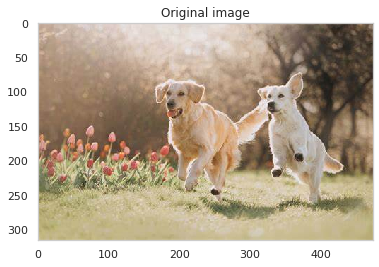

In [146]:
generate_caption_for_unknown_data('/home/EyeForBlind/unknown_data/dogs.jpeg', evaluate=BEAM_EVALUATE)

---
---
<a id='playground'></a>
## Playground

In [ ]:
file_path = 'PROVIDE YOUR FILE PATH'
generate_caption_for_unknown_data(file_path)

---
---